In [1]:
import random
import os
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns
from catboost import CatBoostClassifier
import lightgbm as lgb

import optuna
from optuna import Trial
from optuna.samplers import TPESampler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.utils.class_weight import compute_class_weight

import warnings

warnings.filterwarnings('ignore')

/Users/1233day/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os
import logging

def seed_everything(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

In [3]:
train = pd.read_csv('../train.csv').drop(columns=['ID'])
test = pd.read_csv('../test.csv').drop(columns=['ID'])
train.shape, test.shape
# train.loc[train['시술 당시 나이'] == '알 수 없음', '시술 당시 나이'] = '만43-44세'

((256351, 68), (90067, 67))

In [4]:
train['임신 성공 여부'].value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [5]:
# train['시술 당시 나이'] = train['시술 당시 나이'].replace('알 수 없음','만35-37세')
# test['시술 당시 나이'] = test['시술 당시 나이'].replace('알 수 없음','만35-37세')

train['시술 당시 나이'].value_counts()
# train['']


시술 당시 나이
만18-34세    102476
만35-37세     57780
만38-39세     39247
만40-42세     37348
만43-44세     12253
만45-50세      6918
알 수 없음        329
Name: count, dtype: int64

In [6]:
# drop_columns = ['착상 전 유전 검사 사용 여부',
#                 'PGD 시술 여부', 'PGS 시술 여부', '난자 해동 경과일'] + ['배란 유도 유형', '불임 원인 - 자궁경부 문제', '불임 원인 - 정자 면역학적 요인','불임 원인 - 정자 운동성', '불임 원인 - 정자 형태']#
drop_columns = ['난자 해동 경과일', '배란 유도 유형']
train.drop(columns=drop_columns, inplace=True)
test.drop(columns=drop_columns, inplace=True)

train.shape, test.shape

((256351, 66), (90067, 65))

In [7]:
nan_col_list = ['착상 전 유전 검사 사용 여부','PGD 시술 여부', 'PGS 시술 여부']
for col in nan_col_list:
    train[col] = train[col].fillna(0)
    test[col] = test[col].fillna(0)

In [8]:
drop_columns2 = []
for col in train.columns:
    if len(train[col].value_counts()) == 1:
        drop_columns2.append(col)

In [9]:
print(drop_columns2)
train.drop(columns=drop_columns2, inplace=True)
test.drop(columns=drop_columns2, inplace=True)

train.shape, test.shape

['불임 원인 - 여성 요인', '난자 채취 경과일']


((256351, 64), (90067, 63))

In [10]:
cat_to_int_dict = {'6회 이상' : 6, '5회' : 5, '4회' : 4, '3회' : 3, '2회' : 2, '1회' : 1, '0회' : 0}

cat_to_int_columns = ['총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수','DI 시술 횟수', 'DI 임신 횟수' ,'DI 출산 횟수',
                      '총 임신 횟수', 'IVF 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수'] #
for col in cat_to_int_columns:
    train[col] = train[col].map(cat_to_int_dict)
    test[col] = test[col].map(cat_to_int_dict)

In [11]:
# 5. Binning(구간화) 예시
# 예: 임신 시도 또는 마지막 임신 경과 연수
if '임신 시도 또는 마지막 임신 경과 연수' in train.columns:
    bins = [-0.1, 0.9, 3, 6, 10, 20]  # 0 이하, 1~3, 4~6, 7~10, 11~20
    labels = ['0년 이하','1~3년','4~6년','7~10년','11~20년']
    train['임신시도_bin'] = pd.cut(train['임신 시도 또는 마지막 임신 경과 연수'], bins=bins, labels=labels)
    test['임신시도_bin']  = pd.cut(test['임신 시도 또는 마지막 임신 경과 연수'],  bins=bins, labels=labels)

# 예: 총 생성 배아 수 (0~20, 21이상 구간)
if '총 생성 배아 수' in train.columns:
    bins = [-0.1, 0, 5, 10, 15, 20, 999]
    labels = ['0','1~5','6~10','11~15','16~20','21이상']
    train['총_생성_배아_bin'] = pd.cut(train['총 생성 배아 수'], bins=bins, labels=labels)
    test['총_생성_배아_bin']  = pd.cut(test['총 생성 배아 수'],  bins=bins, labels=labels)

# 6. 희소 범주(rare categories) 병합 예시
def merge_rare_categories(series, min_count=100):
    """
    시리즈 내에서 출현 횟수가 min_count 미만인 카테고리를
    모두 '기타' 카테고리로 통합
    """
    value_counts = series.value_counts(dropna=False)
    rare_cats = value_counts[value_counts < min_count].index
    return series.replace(rare_cats, '기타')


rare_merge_cols = ['특정 시술 유형', '배아 생성 주요 이유']
for col in rare_merge_cols:
    if col in train.columns:
        train[col] = merge_rare_categories(train[col], min_count=100)
    if col in test.columns:
        test[col] = merge_rare_categories(test[col], min_count=100)
train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )


In [12]:
procedure_encoding_dict = {'ICSI' : 'ICSI', 'IVF' : 'IVF', 'Unknown' : 'Unknown','IUI' : 'IUI',
                           'ICSI:ICSI' : 'ICSI', 'ICSI / BLASTOCYST ' : 'ICSI / BLASTOCYST',
                           'IVF / BLASTOCYST' : 'IVF / BLASTOCYST','IVF:IVF' : 'IVF','ICSI:IVF' : 'ICSI:IVF',
                           'ICSI / AH' : 'ICSI / AH','IVF:ICSI' : 'ICSI:IVF', 'IVF / AH' : 'IVF / AH',
                           'ICSI:Unknown' : 'ICSI', 'IVF:Unknown' : 'IVF', 'ICI' : 'ICI','Generic DI' : 'Generic DI',
                           'IVI' : 'IVI','ICSI / BLASTOCYST:IVF / BLASTOCYST' : 'ICSI / BLASTOCYST:IVF / BLASTOCYST',
                           'ICSI / BLASTOCYST :IVF / BLASTOCYST': 'ICSI / BLASTOCYST:IVF / BLASTOCYST','FER' : 'FER',
                           'IVF / AH:ICSI / AH' : 'IVF / AH:ICSI / AH','GIFT':'GIFT','ICSI / AH:Unknown' : 'ICSI / AH',
                           'ICSI / BLASTOCYST :ICSI' : 'ICSI / BLASTOCYST', 'IUI:ICI' : 'IUI:ICI',
                           'IVF:Unknown:Unknown:Unknown' : 'IVF'}

train['특정 시술 유형'] = train['특정 시술 유형'].map(procedure_encoding_dict)
test['특정 시술 유형'] = test['특정 시술 유형'].map(procedure_encoding_dict)

In [13]:
train['불임 원인 - 정자 요인'] = train['불임 원인 - 정자 면역학적 요인'] + train['불임 원인 - 정자 운동성'] + train['불임 원인 - 정자 농도']  + train['불임 원인 - 정자 형태']
test['불임 원인 - 정자 요인'] = test['불임 원인 - 정자 면역학적 요인'] + test['불임 원인 - 정자 운동성'] + test['불임 원인 - 정자 농도'] + test['불임 원인 - 정자 형태']
train['불임 원인 - 여성 요인'] = train['불임 원인 - 자궁경부 문제'] + train['불임 원인 - 자궁내막증'] + train['불임 원인 - 배란 장애'] + train['불임 원인 - 난관 질환']
test['불임 원인 - 여성 요인'] = test['불임 원인 - 자궁경부 문제'] + test['불임 원인 - 자궁내막증'] + test['불임 원인 - 배란 장애'] + test['불임 원인 - 난관 질환']

train['남성 불임 원인'] = train['남성 주 불임 원인'] + train['남성 부 불임 원인']
test['남성 불임 원인'] = test['남성 주 불임 원인'] + test['남성 부 불임 원인']
train['여성 불임 원인'] = train['여성 주 불임 원인'] + train['여성 부 불임 원인']
test['여성 불임 원인'] = test['여성 주 불임 원인'] + test['여성 부 불임 원인']
train['부부 불임 원인'] = train['부부 주 불임 원인'] + train['부부 부 불임 원인']
test['부부 불임 원인'] = test['부부 주 불임 원인'] + test['부부 부 불임 원인']


drop_columns3 = ['불임 원인 - 정자 면역학적 요인', '불임 원인 - 정자 운동성', '불임 원인 - 정자 형태', '불임 원인 - 자궁경부 문제',
                 '남성 주 불임 원인', '남성 부 불임 원인', '여성 주 불임 원인', '여성 부 불임 원인',
                 '부부 주 불임 원인', '부부 부 불임 원인']
train.drop(columns=drop_columns3, inplace=True)
test.drop(columns=drop_columns3, inplace=True)

In [14]:
train.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )
test.drop(columns =['임신 시도 또는 마지막 임신 경과 연수'],inplace = True )

KeyError: "['임신 시도 또는 마지막 임신 경과 연수'] not found in axis"

In [ ]:
train.columns

Index(['시술 시기 코드', '시술 당시 나이', '시술 유형', '특정 시술 유형', '배란 자극 여부', '단일 배아 이식 여부',
       '착상 전 유전 검사 사용 여부', '착상 전 유전 진단 사용 여부', '불명확 불임 원인', '불임 원인 - 난관 질환',
       '불임 원인 - 남성 요인', '불임 원인 - 배란 장애', '불임 원인 - 자궁내막증', '불임 원인 - 정자 농도',
       '배아 생성 주요 이유', '총 시술 횟수', '클리닉 내 총 시술 횟수', 'IVF 시술 횟수', 'DI 시술 횟수',
       '총 임신 횟수', 'IVF 임신 횟수', 'DI 임신 횟수', '총 출산 횟수', 'IVF 출산 횟수', 'DI 출산 횟수',
       '총 생성 배아 수', '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수',
       '미세주입 배아 이식 수', '저장된 배아 수', '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수',
       '수집된 신선 난자 수', '저장된 신선 난자 수', '혼합된 난자 수', '파트너 정자와 혼합된 난자 수',
       '기증자 정자와 혼합된 난자 수', '난자 출처', '정자 출처', '난자 기증자 나이', '정자 기증자 나이',
       '동결 배아 사용 여부', '신선 배아 사용 여부', '기증 배아 사용 여부', '대리모 여부', 'PGD 시술 여부',
       'PGS 시술 여부', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일', '임신 성공 여부',
       '임신시도_bin', '총_생성_배아_bin', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인', '남성 불임 원인',
       '여성 불임 원인', '부부 불임 원인'],
      dtype='object')

In [15]:
# categorical_columns = ["시술 시기 코드","시술 당시 나이", "시술 유형", "특정 시술 유형","배란 자극 여부",
                      #  "단일 배아 이식 여부","착상 전 유전 진단 사용 여부",
                      #  "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
                      #  "부부 주 불임 원인","부부 부 불임 원인","불명확 불임 원인","불임 원인 - 난관 질환",
                      #  "불임 원인 - 남성 요인","불임 원인 - 배란 장애","불임 원인 - 자궁경부 문제","불임 원인 - 자궁내막증",
                      #  "불임 원인 - 정자 농도","불임 원인 - 정자 면역학적 요인","불임 원인 - 정자 운동성","불임 원인 - 정자 형태",
                      #  "배아 생성 주요 이유","총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                      #  "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                      #  "난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                      #  "동결 배아 사용 여부","신선 배아 사용 여부","기증 배아 사용 여부","대리모 여부"]
categorical_columns =  ["시술 시기 코드","시술 당시 나이","시술 유형", "특정 시술 유형",
                        "배란 자극 여부", "단일 배아 이식 여부", '착상 전 유전 검사 사용 여부',"착상 전 유전 진단 사용 여부",
                       "불명확 불임 원인","배아 생성 주요 이유",
                        "불임 원인 - 난관 질환","불임 원인 - 남성 요인","불임 원인 - 배란 장애",
                        "불임 원인 - 자궁내막증",'불임 원인 - 정자 농도',"난자 출처","정자 출처","난자 기증자 나이","정자 기증자 나이",
                       "동결 배아 사용 여부","신선 배아 사용 여부", '기증 배아 사용 여부',"대리모 여부",
                        'PGD 시술 여부', '총_생성_배아_bin','PGS 시술 여부', '불임 원인 - 정자 요인', '불임 원인 - 여성 요인',  '남성 불임 원인', '여성 불임 원인', '부부 불임 원인',"임신시도_bin"] #
# "남성 주 불임 원인","남성 부 불임 원인","여성 주 불임 원인","여성 부 불임 원인",
#                       "부부 주 불임 원인","부부 부 불임 원인",

for col in categorical_columns:
    if train[col].isna().sum() > 0 or test[col].isna().sum() > 0 :

      mode_value = train[col].mode()[0]
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)
    train[col] = train[col].astype(str)
    test[col] = test[col].astype(str)
    #encoder = ce.OrdinalEncoder(handle_unknown='impute')
    #encoder.fit(train[col])
    #train[col] = encoder.transform(train[col])
    #test[col] = encoder.transform(test[col])

numeric_columns = ["총 생성 배아 수", "총 시술 횟수","클리닉 내 총 시술 횟수","IVF 시술 횟수","DI 시술 횟수",
                   "총 임신 횟수","IVF 임신 횟수","DI 임신 횟수","총 출산 횟수","IVF 출산 횟수","DI 출산 횟수",
                    '미세주입된 난자 수', '미세주입에서 생성된 배아 수', '이식된 배아 수', '미세주입 배아 이식 수', '저장된 배아 수',
       '미세주입 후 저장된 배아 수', '해동된 배아 수', '해동 난자 수', '수집된 신선 난자 수', '저장된 신선 난자 수',
       '혼합된 난자 수', '파트너 정자와 혼합된 난자 수', '기증자 정자와 혼합된 난자 수', '난자 혼합 경과일', '배아 이식 경과일', '배아 해동 경과일'] #

# numeric_columns = ["총 생성 배아 수","미세주입된 난자 수","미세주입에서 생성된 배아 수",
#                    "이식된 배아 수","미세주입 배아 이식 수","저장된 배아 수","미세주입 후 저장된 배아 수",
#                    "수집된 신선 난자 수","혼합된 난자 수","파트너 정자와 혼합된 난자 수",
#                    "기증자 정자와 혼합된 난자 수","배아 이식 경과일"]

for col in numeric_columns:
  if train[col].isna().sum():
    if train[col].isna().sum() >= len(train)*0.5: # 결측치가 절반이 넘어갈 경우
      train[col].fillna(-1, inplace=True)  # -1로 대체
      test[col].fillna(-1, inplace = True)
    else:
      mode_value = train[col].mode()[0]  # 최빈값 구하기
      train[col].fillna(mode_value, inplace=True)  # 최빈값으로 대체
      test[col].fillna(mode_value, inplace = True)


In [16]:
len(categorical_columns) + len(numeric_columns)

59

In [17]:
def make_feature(df):
  #df['연령 가중치'] = df['시술 당시 나이'].map(age_weight_dict)

  #df['난자 활용률'] = df['미세주입된 난자 수'] / (df['수집된 신선 난자 수'] + df['해동 난자 수'] + 1)
  df['미세주입 배아 생성률'] = (df['미세주입에서 생성된 배아 수']) / (df['미세주입된 난자 수'] + 1)
  df['미세주입 배아 이식률'] = (df['미세주입 배아 이식 수']) / (df['미세주입에서 생성된 배아 수'] + 1)
  df['배아 이식률'] = (df['이식된 배아 수']) / (df['총 생성 배아 수'] + 1)
  df['저장 배아 비율'] = (df['저장된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['해동 배아 생존율'] = (df['해동된 배아 수'])/ (df['총 생성 배아 수'] + 1)
  df['파트너 정자 혼합 비율'] = (df['파트너 정자와 혼합된 난자 수']) / (df['혼합된 난자 수'] + 1)

  # df['저장 배아 비율2'] = (df['저장된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['해동 배아 생존율2'] = (df['해동된 배아 수'])/ (df['이식된 배아 수'] + 1)
  # df['미세주입 배아 이식 비율'] = df['미세주입 배아 이식 수'] / (df['이식된 배아 수'] + 1)
  #df['나이보정 배아 이식 수'] = df['이식된 배아 수']*df['연령 가중치']

  df['임신 성공률'] = (df['총 임신 횟수']) / (df['총 시술 횟수'] + 1)
  #df['IVF 시술 성공률'] = (df['IVF 임신 횟수'])/ (df['IVF 시술 횟수'] + 1)
  #df['DI 시술 성공률'] = (df['DI 임신 횟수']) / (df['DI 시술 횟수'] + 1)
  df['출산율'] = df['총 출산 횟수'] / (df['총 임신 횟수'] + 1)
  #df['IVF 출산율'] = df['IVF 출산 횟수'] / (df['IVF 임신 횟수'] + 1)
  #df['DI 출산율'] = df['DI 출산 횟수'] / (df['DI 임신 횟수'] + 1)
  #df['시술 기준 출산 성공률'] = df['총 출산 횟수'] / (df['총 시술 횟수'] + 1)

  #df = df.drop(columns = ['연령 가중치'])

  return df

In [18]:
X = train.drop('임신 성공 여부', axis=1)
y = train['임신 성공 여부']

X = make_feature(X)
test = make_feature(test)

X.shape, test.shape

((256351, 67), (90067, 67))

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# 수치형 변수(정수, 실수)를 선택하여 스케일링
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])
test[numeric_cols] = scaler.transform(test[numeric_cols])

X.shape, test.shape

((256351, 67), (90067, 67))

In [20]:
y.value_counts()

임신 성공 여부
0    190123
1     66228
Name: count, dtype: int64

In [21]:
if not os.path.exists('./weight'):
    os.makedirs('./weight')

In [22]:
from sklearn.utils.class_weight import compute_class_weight
def objective_cat(trial):
    global best_val_auc
    cbrm_param = {
        'iterations':trial.suggest_int("iterations", 1500, 3000),
        'depth':trial.suggest_int("depth", 4, 10),
        'learning_rate' : trial.suggest_float('learning_rate',0.005, 0.1),
        'l2_leaf_reg': trial.suggest_float("l2_leaf_reg", 1e-4, 100.0, log=True),
        'early_stopping_rounds': 300
    }

    # Generate model
    model_cat = CatBoostClassifier(**cbrm_param, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed)
    model_cat.fit(X_train,
          y_train,
          cat_features=categorical_columns,
          early_stopping_rounds= 300,
          eval_set=[(X_val,y_val)],
          verbose = 300)
    
    val_auc = model_cat.get_best_score()["validation"]["AUC"]
    best_model_path = "./weight/cat_fold_cpu{}.cbm".format(idx)
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        model_cat.save_model(best_model_path)
        print('저장 완료')

    return val_auc

def objective_lgbm(trial):

    lgbm_params = {
         #'num_leaves': trial.suggest_int('num_leaves', 2, 1024, step=1),
         #'max_depth': trial.suggest_int('max_depth', 3, 18, step=1),
          "num_iterations": trial.suggest_int("num_iterations", 1500, 3000),
        "objective":  trial.suggest_categorical("objective", ["binary"]),
         "metric":  trial.suggest_categorical("metric", ["auc"]),
        #  "random_state":  trial.suggest_int('random_state', 42, 42),
        "random_state": seed,
        "verbose":  trial.suggest_int('verbose', -1, -1),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_samples': trial.suggest_int('min_child_samples', 10, 50, step=5),
        'subsample': trial.suggest_float('subsample', 0.5, 1.0, step=0.1),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0, step=0.1),
    }

    # Generate model

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_params, class_weight=class_weight_dict)

    model_lgbm.fit(X_train, y_train,eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    return model_lgbm.best_score_['valid_0']['auc']

In [23]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    best_val_auc = 0

    sampler = TPESampler(seed=seed)
    optuna_cat = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_cat.optimize(objective_cat, n_trials = 20)
    cat_trial = optuna_cat.best_trial
    cat_trial_params = cat_trial.params
    cat_param_list.append(cat_trial_params)
    
    model = CatBoostClassifier(**cat_trial_params, auto_class_weights='Balanced', eval_metric='AUC', random_state=seed)
    model.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))
    #model = CatBoostClassifier(auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU" )
    #model.fit(X_train,y_train,cat_features=categorical_columns,early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    
    # model_cpu = CatBoostClassifier(auto_class_weights='Balanced',eval_metric='AUC', random_state = 501, task_type="cpu" )
    # model_cpu.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300,eval_set=[(X_val,y_val)], verbose = 300)
    # model_cpu.save_model("cat_fold_{}.cbm".format(idx))


    sampler = TPESampler(seed=seed)
    optuna_lgbm = optuna.create_study(direction='maximize', sampler=sampler)
    optuna_lgbm.optimize(objective_lgbm, n_trials = 40)
    lgbm_trial = optuna_lgbm.best_trial
    lgbm_trial_params = lgbm_trial.params
    lgbm_param_list.append(lgbm_trial_params)
    
    # lgbm_trial_params =loaded_lgbm_params[idx]
    #print(lgbm_trial_params)

    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}
    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    # model_lgbm = lgb.LGBMClassifier(class_weight=class_weight_dict)
    #model_lgbm= lgb.LGBMClassifier(objective = 'binary', metric = 'auc', random_state =  seed, class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (2*val_pred+val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    test_pred = model.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((2*test_pred+test_pred_lgbm)/3)

[I 2025-02-23 06:28:30,990] A new study created in memory with name: no-name-d52b7d42-a62b-49ff-acce-2e42e36f6068


Seed 4972 Start!
0:	test: 0.7161758	best: 0.7161758 (0)	total: 179ms	remaining: 7m 2s
300:	test: 0.7387540	best: 0.7387540 (300)	total: 37.3s	remaining: 4m 15s
600:	test: 0.7400686	best: 0.7400728 (589)	total: 1m 16s	remaining: 3m 43s
900:	test: 0.7406008	best: 0.7406119 (892)	total: 1m 55s	remaining: 3m 7s
1200:	test: 0.7407464	best: 0.7407542 (1190)	total: 2m 37s	remaining: 2m 33s
1500:	test: 0.7408787	best: 0.7408936 (1467)	total: 3m 27s	remaining: 1m 59s
1800:	test: 0.7409551	best: 0.7410085 (1708)	total: 4m 16s	remaining: 1m 20s


[I 2025-02-23 06:33:21,766] Trial 0 finished with value: 0.7410084705745688 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7410084705745688.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410084706
bestIteration = 1708

Shrink model to first 1709 iterations.
저장 완료
0:	test: 0.6946616	best: 0.6946616 (0)	total: 51.8ms	remaining: 1m 53s


Training has stopped (degenerate solution on iteration 232, probably too small l2-regularization, try to increase it)
[I 2025-02-23 06:33:31,712] Trial 1 finished with value: 0.7282318075732872 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7410084705745688.



bestTest = 0.7282318076
bestIteration = 231

Shrink model to first 232 iterations.
0:	test: 0.6946616	best: 0.6946616 (0)	total: 46.6ms	remaining: 1m 58s
300:	test: 0.7408920	best: 0.7408920 (300)	total: 14.2s	remaining: 1m 45s
600:	test: 0.7400776	best: 0.7409930 (315)	total: 29s	remaining: 1m 33s


[I 2025-02-23 06:34:01,581] Trial 2 finished with value: 0.7409929968448441 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7410084705745688.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409929968
bestIteration = 315

Shrink model to first 316 iterations.
0:	test: 0.6946616	best: 0.6946616 (0)	total: 47.5ms	remaining: 1m 50s
300:	test: 0.7391779	best: 0.7391779 (300)	total: 13.6s	remaining: 1m 32s
600:	test: 0.7402539	best: 0.7402637 (597)	total: 28.3s	remaining: 1m 21s
900:	test: 0.7402192	best: 0.7404415 (803)	total: 43.1s	remaining: 1m 8s


[I 2025-02-23 06:34:54,882] Trial 3 finished with value: 0.7404415412298581 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7410084705745688.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404415412
bestIteration = 803

Shrink model to first 804 iterations.
0:	test: 0.7228048	best: 0.7228048 (0)	total: 106ms	remaining: 3m 5s
300:	test: 0.7381428	best: 0.7381428 (300)	total: 37.5s	remaining: 2m 59s
600:	test: 0.7389412	best: 0.7389631 (597)	total: 1m 16s	remaining: 2m 25s
900:	test: 0.7388022	best: 0.7390259 (786)	total: 1m 55s	remaining: 1m 47s


[I 2025-02-23 06:37:17,065] Trial 4 finished with value: 0.7390258795965623 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7410084705745688.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390258796
bestIteration = 786

Shrink model to first 787 iterations.
0:	test: 0.6946616	best: 0.6946616 (0)	total: 47.8ms	remaining: 1m 39s
300:	test: 0.7404055	best: 0.7404070 (299)	total: 13.9s	remaining: 1m 22s
600:	test: 0.7406651	best: 0.7408965 (394)	total: 28.7s	remaining: 1m 10s


[I 2025-02-23 06:37:50,653] Trial 5 finished with value: 0.7408965371794098 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7410084705745688.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408965372
bestIteration = 394

Shrink model to first 395 iterations.
0:	test: 0.6962144	best: 0.6962144 (0)	total: 55.8ms	remaining: 1m 51s
300:	test: 0.7405063	best: 0.7405161 (298)	total: 17.2s	remaining: 1m 36s
600:	test: 0.7412080	best: 0.7412148 (592)	total: 34.8s	remaining: 1m 20s


[I 2025-02-23 06:38:43,485] Trial 6 finished with value: 0.7412148425603788 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7412148425603788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412148426
bestIteration = 592

Shrink model to first 593 iterations.
저장 완료
0:	test: 0.7126516	best: 0.7126516 (0)	total: 67.9ms	remaining: 2m 10s
300:	test: 0.7402127	best: 0.7406367 (155)	total: 24.2s	remaining: 2m 10s


[I 2025-02-23 06:39:20,992] Trial 7 finished with value: 0.7406367000227655 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7412148425603788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7406367
bestIteration = 155

Shrink model to first 156 iterations.
0:	test: 0.7126608	best: 0.7126608 (0)	total: 68.7ms	remaining: 2m 10s
300:	test: 0.7406911	best: 0.7406963 (299)	total: 22.9s	remaining: 2m 2s
600:	test: 0.7405032	best: 0.7408918 (452)	total: 48s	remaining: 1m 44s


[I 2025-02-23 06:40:21,944] Trial 8 finished with value: 0.7408918398680769 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7412148425603788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408918399
bestIteration = 452

Shrink model to first 453 iterations.
0:	test: 0.7096826	best: 0.7096826 (0)	total: 61.4ms	remaining: 2m 41s
300:	test: 0.7401592	best: 0.7401601 (299)	total: 19.7s	remaining: 2m 32s
600:	test: 0.7410061	best: 0.7411606 (470)	total: 41s	remaining: 2m 19s


[I 2025-02-23 06:41:15,950] Trial 9 finished with value: 0.7411605554593284 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7412148425603788.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411605555
bestIteration = 470

Shrink model to first 471 iterations.
0:	test: 0.7096801	best: 0.7096801 (0)	total: 64.2ms	remaining: 3m 8s
300:	test: 0.7409185	best: 0.7409185 (300)	total: 21s	remaining: 3m 4s
600:	test: 0.7414339	best: 0.7415364 (498)	total: 42.7s	remaining: 2m 46s


[I 2025-02-23 06:42:13,074] Trial 10 finished with value: 0.7415363840434073 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7415363840434073.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741536384
bestIteration = 498

Shrink model to first 499 iterations.
저장 완료
0:	test: 0.7097053	best: 0.7097053 (0)	total: 62.6ms	remaining: 3m 7s
300:	test: 0.7405844	best: 0.7406033 (290)	total: 20.3s	remaining: 3m 1s
600:	test: 0.7411199	best: 0.7411331 (593)	total: 41.3s	remaining: 2m 44s
900:	test: 0.7412395	best: 0.7413265 (821)	total: 1m 2s	remaining: 2m 25s


[I 2025-02-23 06:43:31,480] Trial 11 finished with value: 0.7413264662427026 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 10 with value: 0.7415363840434073.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413264662
bestIteration = 821

Shrink model to first 822 iterations.
0:	test: 0.7097047	best: 0.7097047 (0)	total: 60.9ms	remaining: 2m 56s
300:	test: 0.7411432	best: 0.7411452 (297)	total: 19.6s	remaining: 2m 48s
600:	test: 0.7417803	best: 0.7418075 (572)	total: 40.3s	remaining: 2m 33s
900:	test: 0.7418311	best: 0.7418644 (704)	total: 1m 1s	remaining: 2m 15s
1200:	test: 0.7419140	best: 0.7419473 (1169)	total: 1m 22s	remaining: 1m 56s


[I 2025-02-23 06:45:13,561] Trial 12 finished with value: 0.7419473292981775 and parameters: {'iterations': 2897, 'depth': 6, 'learning_rate': 0.06853332055535903, 'l2_leaf_reg': 87.13438924619796}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7419473293
bestIteration = 1169

Shrink model to first 1170 iterations.
저장 완료
0:	test: 0.7126708	best: 0.7126708 (0)	total: 77.6ms	remaining: 3m 50s
300:	test: 0.7405791	best: 0.7405791 (300)	total: 26.4s	remaining: 3m 54s
600:	test: 0.7405330	best: 0.7408797 (443)	total: 54.9s	remaining: 3m 36s


[I 2025-02-23 06:46:22,410] Trial 13 finished with value: 0.7408796816539593 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.0628933885949758, 'l2_leaf_reg': 7.828901342687942}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408796817
bestIteration = 443

Shrink model to first 444 iterations.
0:	test: 0.7181905	best: 0.7181905 (0)	total: 78.5ms	remaining: 3m 36s
300:	test: 0.7396999	best: 0.7396999 (300)	total: 24.9s	remaining: 3m 22s
600:	test: 0.7402756	best: 0.7404333 (518)	total: 52.5s	remaining: 3m 8s


[I 2025-02-23 06:47:36,058] Trial 14 finished with value: 0.7404332901622759 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.030866060002221384, 'l2_leaf_reg': 0.02939703823210393}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404332902
bestIteration = 518

Shrink model to first 519 iterations.
0:	test: 0.7097050	best: 0.7097050 (0)	total: 62.9ms	remaining: 1m 35s
300:	test: 0.7407421	best: 0.7407514 (296)	total: 20.6s	remaining: 1m 22s
600:	test: 0.7406826	best: 0.7408506 (437)	total: 41.8s	remaining: 1m 3s


[I 2025-02-23 06:48:27,912] Trial 15 finished with value: 0.7408506043835532 and parameters: {'iterations': 1513, 'depth': 6, 'learning_rate': 0.08625378621185843, 'l2_leaf_reg': 9.663069382488304}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408506044
bestIteration = 437

Shrink model to first 438 iterations.
0:	test: 0.7181964	best: 0.7181964 (0)	total: 76.3ms	remaining: 3m 35s
300:	test: 0.7408305	best: 0.7408389 (297)	total: 26.5s	remaining: 3m 42s
600:	test: 0.7403778	best: 0.7408479 (318)	total: 55.7s	remaining: 3m 25s


[I 2025-02-23 06:49:25,489] Trial 16 finished with value: 0.7408478527041333 and parameters: {'iterations': 2824, 'depth': 8, 'learning_rate': 0.061662991475729484, 'l2_leaf_reg': 1.8341589839267998}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408478527
bestIteration = 318

Shrink model to first 319 iterations.
0:	test: 0.6962144	best: 0.6962144 (0)	total: 58.7ms	remaining: 2m 29s
300:	test: 0.7405460	best: 0.7405460 (300)	total: 17.2s	remaining: 2m 8s
600:	test: 0.7411116	best: 0.7411116 (600)	total: 34.8s	remaining: 1m 52s
900:	test: 0.7412044	best: 0.7412244 (881)	total: 52.7s	remaining: 1m 36s
1200:	test: 0.7412922	best: 0.7413022 (1184)	total: 1m 10s	remaining: 1m 19s
1500:	test: 0.7412923	best: 0.7413411 (1346)	total: 1m 29s	remaining: 1m 2s


[I 2025-02-23 06:51:03,694] Trial 17 finished with value: 0.7413410545113728 and parameters: {'iterations': 2546, 'depth': 5, 'learning_rate': 0.0774911016692127, 'l2_leaf_reg': 80.62911323694684}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7413410545
bestIteration = 1346

Shrink model to first 1347 iterations.
0:	test: 0.7126516	best: 0.7126516 (0)	total: 67.5ms	remaining: 3m 9s
300:	test: 0.7403266	best: 0.7404758 (280)	total: 23.1s	remaining: 3m 13s


[I 2025-02-23 06:51:50,208] Trial 18 finished with value: 0.7404758399410103 and parameters: {'iterations': 2815, 'depth': 7, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 12 with value: 0.7419473292981775.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404758399
bestIteration = 280

Shrink model to first 281 iterations.
0:	test: 0.6962156	best: 0.6962156 (0)	total: 54.4ms	remaining: 2m 13s
300:	test: 0.7390692	best: 0.7390715 (298)	total: 16.4s	remaining: 1m 57s
600:	test: 0.7407096	best: 0.7407156 (599)	total: 34.1s	remaining: 1m 45s
900:	test: 0.7410902	best: 0.7411116 (878)	total: 52.1s	remaining: 1m 30s
1200:	test: 0.7409903	best: 0.7411384 (1030)	total: 1m 10s	remaining: 1m 13s


[I 2025-02-23 06:53:08,653] Trial 19 finished with value: 0.7411383633434879 and parameters: {'iterations': 2460, 'depth': 5, 'learning_rate': 0.032760769261710856, 'l2_leaf_reg': 0.31055845032241847}. Best is trial 12 with value: 0.7419473292981775.
[I 2025-02-23 06:53:08,656] A new study created in memory with name: no-name-e7059ea7-b33e-4863-9f8e-df8a5bbd4d77


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7411383633
bestIteration = 1030

Shrink model to first 1031 iterations.


[I 2025-02-23 06:53:31,556] Trial 0 finished with value: 0.7312648213970655 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7312648213970655.
[I 2025-02-23 06:53:48,346] Trial 1 finished with value: 0.740679198182694 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.740679198182694.
[I 2025-02-23 06:54:07,898] Trial 2 finished with value: 0.7407712424548891 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best

Cat val score : 0.7419473292981775
LGBM val score : 0.7409660081507365
Ensemble val score : 0.7420357721659947


[I 2025-02-23 07:06:12,455] A new study created in memory with name: no-name-2d7c2355-2cbb-4235-8f42-401861618258


0:	test: 0.7227589	best: 0.7227589 (0)	total: 135ms	remaining: 5m 18s
300:	test: 0.7330597	best: 0.7330597 (300)	total: 39.3s	remaining: 4m 29s
600:	test: 0.7344199	best: 0.7344225 (596)	total: 1m 20s	remaining: 3m 56s
900:	test: 0.7348073	best: 0.7348178 (897)	total: 2m 2s	remaining: 3m 18s
1200:	test: 0.7350766	best: 0.7350805 (1198)	total: 2m 46s	remaining: 2m 41s
1500:	test: 0.7351321	best: 0.7351767 (1430)	total: 3m 34s	remaining: 2m 3s


[I 2025-02-23 07:10:25,665] Trial 0 finished with value: 0.7351766526465233 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351766526
bestIteration = 1430

Shrink model to first 1431 iterations.
저장 완료
0:	test: 0.6888096	best: 0.6888096 (0)	total: 53.5ms	remaining: 1m 57s
300:	test: 0.7236600	best: 0.7236600 (300)	total: 12.9s	remaining: 1m 21s


Training has stopped (degenerate solution on iteration 346, probably too small l2-regularization, try to increase it)
[I 2025-02-23 07:10:40,656] Trial 1 finished with value: 0.7247429245465473 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7351766526465233.



bestTest = 0.7247429245
bestIteration = 345

Shrink model to first 346 iterations.
0:	test: 0.6888096	best: 0.6888096 (0)	total: 53.8ms	remaining: 2m 16s
300:	test: 0.7343409	best: 0.7343409 (300)	total: 14.1s	remaining: 1m 44s
600:	test: 0.7340241	best: 0.7344169 (352)	total: 28.9s	remaining: 1m 33s


[I 2025-02-23 07:11:12,290] Trial 2 finished with value: 0.7344168798461395 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7344168798
bestIteration = 352

Shrink model to first 353 iterations.
0:	test: 0.6888096	best: 0.6888096 (0)	total: 54.2ms	remaining: 2m 6s
300:	test: 0.7337850	best: 0.7337850 (300)	total: 13.6s	remaining: 1m 31s
600:	test: 0.7344127	best: 0.7346932 (516)	total: 28.1s	remaining: 1m 20s


[I 2025-02-23 07:11:50,996] Trial 3 finished with value: 0.7346932330694971 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7346932331
bestIteration = 516

Shrink model to first 517 iterations.
0:	test: 0.7227306	best: 0.7227306 (0)	total: 131ms	remaining: 3m 48s
300:	test: 0.7326636	best: 0.7326759 (298)	total: 36.5s	remaining: 2m 54s
600:	test: 0.7334423	best: 0.7334554 (590)	total: 1m 16s	remaining: 2m 24s


[I 2025-02-23 07:13:47,072] Trial 4 finished with value: 0.7334553622032569 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7334553622
bestIteration = 590

Shrink model to first 591 iterations.
0:	test: 0.6888096	best: 0.6888096 (0)	total: 53.2ms	remaining: 1m 50s
300:	test: 0.7344814	best: 0.7344814 (300)	total: 14s	remaining: 1m 22s
600:	test: 0.7345071	best: 0.7346733 (566)	total: 28.7s	remaining: 1m 10s
900:	test: 0.7345130	best: 0.7346927 (821)	total: 43.5s	remaining: 57.1s


[I 2025-02-23 07:14:41,645] Trial 5 finished with value: 0.734692748573704 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7346927486
bestIteration = 821

Shrink model to first 822 iterations.
0:	test: 0.6975347	best: 0.6975347 (0)	total: 62.8ms	remaining: 2m 5s
300:	test: 0.7349218	best: 0.7349218 (298)	total: 17.3s	remaining: 1m 37s
600:	test: 0.7350271	best: 0.7351283 (475)	total: 35s	remaining: 1m 21s
900:	test: 0.7351566	best: 0.7351754 (747)	total: 52.8s	remaining: 1m 4s


[I 2025-02-23 07:15:43,431] Trial 6 finished with value: 0.7351754175793787 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351754176
bestIteration = 747

Shrink model to first 748 iterations.
0:	test: 0.7121280	best: 0.7121280 (0)	total: 82.7ms	remaining: 2m 39s
300:	test: 0.7342498	best: 0.7347529 (166)	total: 23.8s	remaining: 2m 8s


[I 2025-02-23 07:16:21,401] Trial 7 finished with value: 0.7347529015063101 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7351766526465233.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7347529015
bestIteration = 166

Shrink model to first 167 iterations.
0:	test: 0.7121274	best: 0.7121274 (0)	total: 82.3ms	remaining: 2m 36s
300:	test: 0.7352481	best: 0.7353171 (297)	total: 22.9s	remaining: 2m 1s
600:	test: 0.7351487	best: 0.7354021 (413)	total: 47.7s	remaining: 1m 43s


[I 2025-02-23 07:17:18,650] Trial 8 finished with value: 0.7354020662998975 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7354020663
bestIteration = 413

Shrink model to first 414 iterations.
저장 완료
0:	test: 0.7118659	best: 0.7118659 (0)	total: 76.4ms	remaining: 3m 21s
300:	test: 0.7343442	best: 0.7343819 (297)	total: 19.5s	remaining: 2m 31s
600:	test: 0.7349371	best: 0.7350599 (487)	total: 40.9s	remaining: 2m 18s


[I 2025-02-23 07:18:13,333] Trial 9 finished with value: 0.7350599487295433 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350599487
bestIteration = 487

Shrink model to first 488 iterations.
0:	test: 0.7154641	best: 0.7154641 (0)	total: 97.3ms	remaining: 4m 46s
300:	test: 0.7343450	best: 0.7343450 (300)	total: 25.4s	remaining: 3m 43s
600:	test: 0.7351176	best: 0.7352153 (505)	total: 53.5s	remaining: 3m 28s


[I 2025-02-23 07:19:26,947] Trial 10 finished with value: 0.7352152812578299 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.87526046512315}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352152813
bestIteration = 505

Shrink model to first 506 iterations.
0:	test: 0.7154648	best: 0.7154648 (0)	total: 95.9ms	remaining: 4m 47s
300:	test: 0.7345951	best: 0.7345980 (298)	total: 25.4s	remaining: 3m 47s
600:	test: 0.7353313	best: 0.7353494 (593)	total: 53.3s	remaining: 3m 32s
900:	test: 0.7349323	best: 0.7353888 (629)	total: 1m 22s	remaining: 3m 11s


[I 2025-02-23 07:20:52,126] Trial 11 finished with value: 0.7353887506081416 and parameters: {'iterations': 2994, 'depth': 8, 'learning_rate': 0.031221552622542375, 'l2_leaf_reg': 0.4673950385408126}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7353887506
bestIteration = 629

Shrink model to first 630 iterations.
0:	test: 0.7154648	best: 0.7154648 (0)	total: 94.7ms	remaining: 2m 28s
300:	test: 0.7337962	best: 0.7344370 (216)	total: 26.4s	remaining: 1m 50s


[I 2025-02-23 07:21:39,631] Trial 12 finished with value: 0.7344369903928296 and parameters: {'iterations': 1565, 'depth': 8, 'learning_rate': 0.061287874640168535, 'l2_leaf_reg': 0.028450890806958902}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7344369904
bestIteration = 216

Shrink model to first 217 iterations.
0:	test: 0.7154746	best: 0.7154746 (0)	total: 97ms	remaining: 4m 48s
300:	test: 0.7343632	best: 0.7343650 (299)	total: 25.1s	remaining: 3m 43s
600:	test: 0.7350954	best: 0.7350954 (600)	total: 51.9s	remaining: 3m 25s
900:	test: 0.7348994	best: 0.7351569 (676)	total: 1m 20s	remaining: 3m 5s


[I 2025-02-23 07:23:07,745] Trial 13 finished with value: 0.7351569273137013 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.026319078501895434, 'l2_leaf_reg': 2.079573379652083}. Best is trial 8 with value: 0.7354020662998975.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7351569273
bestIteration = 676

Shrink model to first 677 iterations.
0:	test: 0.7121233	best: 0.7121233 (0)	total: 82.7ms	remaining: 3m 43s
300:	test: 0.7352129	best: 0.7352129 (300)	total: 23s	remaining: 3m 3s
600:	test: 0.7352602	best: 0.7354736 (441)	total: 47.8s	remaining: 2m 47s


[I 2025-02-23 07:24:07,464] Trial 14 finished with value: 0.7354736207687493 and parameters: {'iterations': 2702, 'depth': 7, 'learning_rate': 0.0536289472022267, 'l2_leaf_reg': 5.542114755250782}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7354736208
bestIteration = 441

Shrink model to first 442 iterations.
저장 완료
0:	test: 0.7118659	best: 0.7118659 (0)	total: 75.8ms	remaining: 3m 23s
300:	test: 0.7348053	best: 0.7348190 (296)	total: 19.7s	remaining: 2m 35s
600:	test: 0.7351223	best: 0.7351451 (586)	total: 40.9s	remaining: 2m 21s
900:	test: 0.7350383	best: 0.7352107 (725)	total: 1m 2s	remaining: 2m 3s


[I 2025-02-23 07:25:18,720] Trial 15 finished with value: 0.7352107420882275 and parameters: {'iterations': 2684, 'depth': 6, 'learning_rate': 0.05665316438649348, 'l2_leaf_reg': 16.81902590307642}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352107421
bestIteration = 725

Shrink model to first 726 iterations.
0:	test: 0.7121241	best: 0.7121241 (0)	total: 83ms	remaining: 2m 28s
300:	test: 0.7350853	best: 0.7351682 (250)	total: 23.4s	remaining: 1m 56s
600:	test: 0.7349781	best: 0.7352024 (320)	total: 48.6s	remaining: 1m 36s


[I 2025-02-23 07:26:09,094] Trial 16 finished with value: 0.7352023587224961 and parameters: {'iterations': 1793, 'depth': 7, 'learning_rate': 0.07180185194389979, 'l2_leaf_reg': 3.055459031171782}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7352023587
bestIteration = 320

Shrink model to first 321 iterations.
0:	test: 0.7200459	best: 0.7200459 (0)	total: 112ms	remaining: 3m 1s
300:	test: 0.7338165	best: 0.7338989 (276)	total: 29.8s	remaining: 2m 10s


[I 2025-02-23 07:27:09,648] Trial 17 finished with value: 0.7338989181018318 and parameters: {'iterations': 1618, 'depth': 9, 'learning_rate': 0.05122368438861319, 'l2_leaf_reg': 0.016368401574579163}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7338989181
bestIteration = 276

Shrink model to first 277 iterations.
0:	test: 0.7118585	best: 0.7118585 (0)	total: 76.2ms	remaining: 3m 33s
300:	test: 0.7344773	best: 0.7345113 (296)	total: 20.1s	remaining: 2m 47s
600:	test: 0.7349343	best: 0.7349535 (544)	total: 41.2s	remaining: 2m 31s
900:	test: 0.7349823	best: 0.7350306 (810)	total: 1m 1s	remaining: 2m 11s


[I 2025-02-23 07:28:26,630] Trial 18 finished with value: 0.7350306208489532 and parameters: {'iterations': 2806, 'depth': 6, 'learning_rate': 0.06566065400200083, 'l2_leaf_reg': 70.64174190249958}. Best is trial 14 with value: 0.7354736207687493.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7350306208
bestIteration = 810

Shrink model to first 811 iterations.
0:	test: 0.7121280	best: 0.7121280 (0)	total: 80.1ms	remaining: 3m 16s
300:	test: 0.7345898	best: 0.7347519 (241)	total: 23.8s	remaining: 2m 50s


[I 2025-02-23 07:29:10,835] Trial 19 finished with value: 0.7347518769168461 and parameters: {'iterations': 2455, 'depth': 7, 'learning_rate': 0.08088060835396044, 'l2_leaf_reg': 0.15888451859639016}. Best is trial 14 with value: 0.7354736207687493.
[I 2025-02-23 07:29:10,838] A new study created in memory with name: no-name-fdecc907-b0e9-4e74-a861-7787b9a8970e


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7347518769
bestIteration = 241

Shrink model to first 242 iterations.


[I 2025-02-23 07:29:33,694] Trial 0 finished with value: 0.726921535334445 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.726921535334445.
[I 2025-02-23 07:29:50,458] Trial 1 finished with value: 0.734983255428263 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.734983255428263.
[I 2025-02-23 07:30:09,944] Trial 2 finished with value: 0.7344062884504002 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Best i

Cat val score : 0.7354736207687493
LGBM val score : 0.7349416364453811
Ensemble val score : 0.7356523361759681


[I 2025-02-23 07:40:49,799] A new study created in memory with name: no-name-07e9d031-207b-49eb-bfdb-0063db2016bb


0:	test: 0.7276999	best: 0.7276999 (0)	total: 130ms	remaining: 5m 7s
300:	test: 0.7398668	best: 0.7398668 (300)	total: 39s	remaining: 4m 27s
600:	test: 0.7415244	best: 0.7415244 (600)	total: 1m 19s	remaining: 3m 53s
900:	test: 0.7421781	best: 0.7421802 (899)	total: 2m	remaining: 3m 15s
1200:	test: 0.7424817	best: 0.7424817 (1200)	total: 2m 42s	remaining: 2m 37s
1500:	test: 0.7426042	best: 0.7426087 (1497)	total: 3m 30s	remaining: 2m 1s


[I 2025-02-23 07:45:08,702] Trial 0 finished with value: 0.7426087347157264 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7426087347157264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426087347
bestIteration = 1497

Shrink model to first 1498 iterations.
저장 완료
0:	test: 0.6943640	best: 0.6943640 (0)	total: 54.9ms	remaining: 2m
300:	test: 0.7293559	best: 0.7293559 (300)	total: 12.9s	remaining: 1m 21s
600:	test: 0.7343203	best: 0.7343203 (600)	total: 25.8s	remaining: 1m 8s
900:	test: 0.7366064	best: 0.7366064 (900)	total: 39.1s	remaining: 56.1s
1200:	test: 0.7379071	best: 0.7379071 (1200)	total: 52.6s	remaining: 43.5s
1500:	test: 0.7387880	best: 0.7387880 (1500)	total: 1m 6s	remaining: 30.6s
1800:	test: 0.7393767	best: 0.7393771 (1799)	total: 1m 20s	remaining: 17.5s
2100:	test: 0.7398518	best: 0.7398518 (2100)	total: 1m 34s	remaining: 4.12s


[I 2025-02-23 07:46:47,470] Trial 1 finished with value: 0.740013040561686 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7426087347157264.


2192:	test: 0.7400130	best: 0.7400130 (2192)	total: 1m 38s	remaining: 0us

bestTest = 0.7400130406
bestIteration = 2192

0:	test: 0.6943640	best: 0.6943640 (0)	total: 57ms	remaining: 2m 24s
300:	test: 0.7417021	best: 0.7417255 (297)	total: 14.1s	remaining: 1m 44s
600:	test: 0.7419565	best: 0.7420987 (559)	total: 28.7s	remaining: 1m 32s


[I 2025-02-23 07:47:29,216] Trial 2 finished with value: 0.742098703611573 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7426087347157264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420987036
bestIteration = 559

Shrink model to first 560 iterations.
0:	test: 0.6943640	best: 0.6943640 (0)	total: 51.6ms	remaining: 2m
300:	test: 0.7403322	best: 0.7403322 (300)	total: 13.6s	remaining: 1m 32s
600:	test: 0.7413935	best: 0.7414061 (598)	total: 28.1s	remaining: 1m 20s
900:	test: 0.7416791	best: 0.7416791 (900)	total: 42.7s	remaining: 1m 7s
1200:	test: 0.7415712	best: 0.7417196 (1030)	total: 57.4s	remaining: 54.2s


[I 2025-02-23 07:48:33,316] Trial 3 finished with value: 0.7417195737396481 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7426087347157264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417195737
bestIteration = 1030

Shrink model to first 1031 iterations.
0:	test: 0.7276673	best: 0.7276673 (0)	total: 133ms	remaining: 3m 52s
300:	test: 0.7395024	best: 0.7395024 (300)	total: 37.3s	remaining: 2m 58s
600:	test: 0.7403629	best: 0.7404228 (516)	total: 1m 15s	remaining: 2m 24s
900:	test: 0.7403105	best: 0.7404553 (616)	total: 1m 55s	remaining: 1m 47s


[I 2025-02-23 07:50:31,201] Trial 4 finished with value: 0.7404552700537455 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7426087347157264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404552701
bestIteration = 616

Shrink model to first 617 iterations.
0:	test: 0.6943640	best: 0.6943640 (0)	total: 55.6ms	remaining: 1m 55s
300:	test: 0.7412453	best: 0.7412484 (299)	total: 14s	remaining: 1m 22s
600:	test: 0.7415411	best: 0.7416729 (470)	total: 28.7s	remaining: 1m 10s


[I 2025-02-23 07:51:08,414] Trial 5 finished with value: 0.7416729032924316 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7426087347157264.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416729033
bestIteration = 470

Shrink model to first 471 iterations.
0:	test: 0.7028774	best: 0.7028774 (0)	total: 65.1ms	remaining: 2m 9s
300:	test: 0.7420459	best: 0.7420459 (300)	total: 17.1s	remaining: 1m 36s
600:	test: 0.7426518	best: 0.7426518 (600)	total: 35.3s	remaining: 1m 22s
900:	test: 0.7427593	best: 0.7427853 (784)	total: 53.3s	remaining: 1m 4s


[I 2025-02-23 07:52:13,062] Trial 6 finished with value: 0.7427853413748622 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7427853413748622.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427853414
bestIteration = 784

Shrink model to first 785 iterations.
저장 완료
0:	test: 0.7176315	best: 0.7176315 (0)	total: 81.5ms	remaining: 2m 37s
300:	test: 0.7414624	best: 0.7423255 (197)	total: 24s	remaining: 2m 9s


[I 2025-02-23 07:52:53,637] Trial 7 finished with value: 0.7423254635278477 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7427853413748622.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423254635
bestIteration = 197

Shrink model to first 198 iterations.
0:	test: 0.7176310	best: 0.7176310 (0)	total: 80.8ms	remaining: 2m 33s
300:	test: 0.7418203	best: 0.7418550 (293)	total: 22.7s	remaining: 2m 1s
600:	test: 0.7417616	best: 0.7420941 (452)	total: 47.8s	remaining: 1m 43s


[I 2025-02-23 07:53:54,458] Trial 8 finished with value: 0.7420940850164307 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7427853413748622.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742094085
bestIteration = 452

Shrink model to first 453 iterations.
0:	test: 0.7175361	best: 0.7175361 (0)	total: 72.7ms	remaining: 3m 11s
300:	test: 0.7414517	best: 0.7414517 (300)	total: 19.4s	remaining: 2m 30s
600:	test: 0.7424594	best: 0.7424951 (594)	total: 40.9s	remaining: 2m 18s
900:	test: 0.7424805	best: 0.7425823 (748)	total: 1m 2s	remaining: 2m


[I 2025-02-23 07:55:08,232] Trial 9 finished with value: 0.742582305867341 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7427853413748622.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425823059
bestIteration = 748

Shrink model to first 749 iterations.
0:	test: 0.7175361	best: 0.7175361 (0)	total: 72.7ms	remaining: 3m 33s
300:	test: 0.7421740	best: 0.7421740 (300)	total: 20.3s	remaining: 2m 58s
600:	test: 0.7427999	best: 0.7427999 (600)	total: 41.6s	remaining: 2m 42s
900:	test: 0.7428935	best: 0.7429361 (815)	total: 1m 3s	remaining: 2m 23s
1200:	test: 0.7428247	best: 0.7429930 (1001)	total: 1m 24s	remaining: 2m 2s


[I 2025-02-23 07:56:40,110] Trial 10 finished with value: 0.7429930391615726 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429930392
bestIteration = 1001

Shrink model to first 1002 iterations.
저장 완료
0:	test: 0.7175361	best: 0.7175361 (0)	total: 73.9ms	remaining: 3m 41s
300:	test: 0.7422888	best: 0.7423082 (290)	total: 19.8s	remaining: 2m 57s
600:	test: 0.7426348	best: 0.7426367 (596)	total: 41.2s	remaining: 2m 43s
900:	test: 0.7427150	best: 0.7427343 (883)	total: 1m 2s	remaining: 2m 24s
1200:	test: 0.7425930	best: 0.7427547 (923)	total: 1m 23s	remaining: 2m 4s


[I 2025-02-23 07:58:05,632] Trial 11 finished with value: 0.7427547188579726 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427547189
bestIteration = 923

Shrink model to first 924 iterations.
0:	test: 0.7175361	best: 0.7175361 (0)	total: 75.1ms	remaining: 1m 59s
300:	test: 0.7422580	best: 0.7422858 (263)	total: 19.9s	remaining: 1m 25s
600:	test: 0.7425953	best: 0.7426511 (542)	total: 41.1s	remaining: 1m 7s
900:	test: 0.7427282	best: 0.7427504 (893)	total: 1m 2s	remaining: 47.7s
1200:	test: 0.7426707	best: 0.7427580 (992)	total: 1m 23s	remaining: 27s


[I 2025-02-23 07:59:36,422] Trial 12 finished with value: 0.7427580070753224 and parameters: {'iterations': 1588, 'depth': 6, 'learning_rate': 0.07382783813729096, 'l2_leaf_reg': 87.13438924619796}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427580071
bestIteration = 992

Shrink model to first 993 iterations.
0:	test: 0.7028774	best: 0.7028774 (0)	total: 62.7ms	remaining: 3m 6s
300:	test: 0.7422585	best: 0.7423140 (280)	total: 17.6s	remaining: 2m 35s
600:	test: 0.7425258	best: 0.7425567 (532)	total: 35.7s	remaining: 2m 20s


[I 2025-02-23 08:00:26,347] Trial 13 finished with value: 0.742556707015847 and parameters: {'iterations': 2975, 'depth': 5, 'learning_rate': 0.07888750974731618, 'l2_leaf_reg': 6.819372056732044}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742556707
bestIteration = 532

Shrink model to first 533 iterations.
0:	test: 0.7201628	best: 0.7201628 (0)	total: 94.4ms	remaining: 4m 15s
300:	test: 0.7425150	best: 0.7425439 (283)	total: 26.3s	remaining: 3m 29s
600:	test: 0.7423875	best: 0.7428031 (459)	total: 55.4s	remaining: 3m 13s


[I 2025-02-23 08:01:37,286] Trial 14 finished with value: 0.742803053270249 and parameters: {'iterations': 2702, 'depth': 8, 'learning_rate': 0.06308101933412968, 'l2_leaf_reg': 11.438982664164415}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428030533
bestIteration = 459

Shrink model to first 460 iterations.
0:	test: 0.7243393	best: 0.7243393 (0)	total: 107ms	remaining: 4m 53s
300:	test: 0.7418302	best: 0.7418302 (300)	total: 28s	remaining: 3m 47s
600:	test: 0.7425456	best: 0.7425850 (588)	total: 1m	remaining: 3m 37s


[I 2025-02-23 08:03:10,510] Trial 15 finished with value: 0.7425849507378179 and parameters: {'iterations': 2753, 'depth': 9, 'learning_rate': 0.03259885190735587, 'l2_leaf_reg': 4.722389127363701}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425849507
bestIteration = 588

Shrink model to first 589 iterations.
0:	test: 0.7201725	best: 0.7201725 (0)	total: 92.4ms	remaining: 4m 19s
300:	test: 0.7414156	best: 0.7414949 (210)	total: 26.1s	remaining: 3m 37s
600:	test: 0.7399978	best: 0.7415978 (374)	total: 55s	remaining: 3m 22s


[I 2025-02-23 08:04:12,864] Trial 16 finished with value: 0.7415977548179016 and parameters: {'iterations': 2815, 'depth': 8, 'learning_rate': 0.061662991475729484, 'l2_leaf_reg': 0.03562900678874207}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415977548
bestIteration = 374

Shrink model to first 375 iterations.
0:	test: 0.7201714	best: 0.7201714 (0)	total: 95.7ms	remaining: 4m 5s
300:	test: 0.7424920	best: 0.7425204 (279)	total: 26.3s	remaining: 3m 17s
600:	test: 0.7418196	best: 0.7425790 (311)	total: 55.4s	remaining: 3m 1s


[I 2025-02-23 08:05:09,465] Trial 17 finished with value: 0.7425789501382822 and parameters: {'iterations': 2565, 'depth': 8, 'learning_rate': 0.06074791161960117, 'l2_leaf_reg': 0.5610725433980096}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425789501
bestIteration = 311

Shrink model to first 312 iterations.
0:	test: 0.7201599	best: 0.7201599 (0)	total: 93.2ms	remaining: 4m 22s
300:	test: 0.7415299	best: 0.7415299 (300)	total: 25s	remaining: 3m 28s
600:	test: 0.7424543	best: 0.7424759 (573)	total: 52.3s	remaining: 3m 13s
900:	test: 0.7425048	best: 0.7425999 (718)	total: 1m 20s	remaining: 2m 52s


[I 2025-02-23 08:06:41,828] Trial 18 finished with value: 0.742599886710587 and parameters: {'iterations': 2818, 'depth': 8, 'learning_rate': 0.031028793579317128, 'l2_leaf_reg': 18.78674759977375}. Best is trial 10 with value: 0.7429930391615726.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425998867
bestIteration = 718

Shrink model to first 719 iterations.
0:	test: 0.7176315	best: 0.7176315 (0)	total: 80ms	remaining: 3m 16s
300:	test: 0.7420142	best: 0.7420142 (300)	total: 23.6s	remaining: 2m 49s


[I 2025-02-23 08:07:33,066] Trial 19 finished with value: 0.7420142424924954 and parameters: {'iterations': 2460, 'depth': 7, 'learning_rate': 0.0869018854727605, 'l2_leaf_reg': 0.011209249875988852}. Best is trial 10 with value: 0.7429930391615726.
[I 2025-02-23 08:07:33,069] A new study created in memory with name: no-name-1a95a059-ca6f-436d-8104-4ad55f262ed2


600:	test: 0.7404285	best: 0.7420142 (300)	total: 51.1s	remaining: 2m 38s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420142425
bestIteration = 300

Shrink model to first 301 iterations.


[I 2025-02-23 08:07:56,097] Trial 0 finished with value: 0.7334550008170505 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7334550008170505.
[I 2025-02-23 08:08:12,902] Trial 1 finished with value: 0.7426047793238418 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7426047793238418.
[I 2025-02-23 08:08:32,423] Trial 2 finished with value: 0.7420182177407649 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7429930391615726
LGBM val score : 0.7426731964838695
Ensemble val score : 0.7432124720717959


[I 2025-02-23 08:20:03,417] A new study created in memory with name: no-name-f1e22bd6-6a21-41bc-b67b-04fe58d3137f


0:	test: 0.7276354	best: 0.7276354 (0)	total: 131ms	remaining: 5m 9s
300:	test: 0.7393553	best: 0.7393553 (300)	total: 39s	remaining: 4m 27s
600:	test: 0.7408718	best: 0.7408718 (600)	total: 1m 20s	remaining: 3m 57s
900:	test: 0.7412751	best: 0.7412751 (900)	total: 2m 1s	remaining: 3m 16s
1200:	test: 0.7416185	best: 0.7416207 (1197)	total: 2m 46s	remaining: 2m 41s
1500:	test: 0.7417440	best: 0.7417550 (1496)	total: 3m 36s	remaining: 2m 4s
1800:	test: 0.7416225	best: 0.7417667 (1545)	total: 4m 26s	remaining: 1m 23s


[I 2025-02-23 08:24:38,584] Trial 0 finished with value: 0.7417667327348012 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417667327
bestIteration = 1545

Shrink model to first 1546 iterations.
저장 완료
0:	test: 0.6977785	best: 0.6977785 (0)	total: 53.7ms	remaining: 1m 57s
300:	test: 0.7302361	best: 0.7302361 (300)	total: 12.9s	remaining: 1m 21s
600:	test: 0.7345481	best: 0.7345481 (600)	total: 25.8s	remaining: 1m 8s
900:	test: 0.7364696	best: 0.7364696 (900)	total: 39.2s	remaining: 56.2s
1200:	test: 0.7373969	best: 0.7373969 (1200)	total: 52.8s	remaining: 43.6s
1500:	test: 0.7379846	best: 0.7379846 (1500)	total: 1m 6s	remaining: 30.7s
1800:	test: 0.7383823	best: 0.7383823 (1800)	total: 1m 20s	remaining: 17.5s
2100:	test: 0.7387894	best: 0.7387905 (2099)	total: 1m 34s	remaining: 4.13s


[I 2025-02-23 08:26:17,414] Trial 1 finished with value: 0.7389434485126474 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7417667327348012.


2192:	test: 0.7389427	best: 0.7389434 (2191)	total: 1m 38s	remaining: 0us

bestTest = 0.7389434485
bestIteration = 2191

Shrink model to first 2192 iterations.
0:	test: 0.6977785	best: 0.6977785 (0)	total: 51.8ms	remaining: 2m 11s
300:	test: 0.7400714	best: 0.7400783 (295)	total: 14.2s	remaining: 1m 45s
600:	test: 0.7396923	best: 0.7401265 (362)	total: 28.9s	remaining: 1m 32s


[I 2025-02-23 08:26:49,524] Trial 2 finished with value: 0.740126498616432 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7401264986
bestIteration = 362

Shrink model to first 363 iterations.
0:	test: 0.6977785	best: 0.6977785 (0)	total: 52.4ms	remaining: 2m 2s
300:	test: 0.7392826	best: 0.7392826 (300)	total: 13.7s	remaining: 1m 32s
600:	test: 0.7401348	best: 0.7401357 (593)	total: 28.2s	remaining: 1m 21s
900:	test: 0.7402464	best: 0.7404161 (686)	total: 42.9s	remaining: 1m 8s


[I 2025-02-23 08:27:36,856] Trial 3 finished with value: 0.7404160874070205 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404160874
bestIteration = 686

Shrink model to first 687 iterations.
0:	test: 0.7276728	best: 0.7276728 (0)	total: 132ms	remaining: 3m 49s
300:	test: 0.7389076	best: 0.7389096 (299)	total: 37.3s	remaining: 2m 58s
600:	test: 0.7397227	best: 0.7397236 (598)	total: 1m 16s	remaining: 2m 25s
900:	test: 0.7398770	best: 0.7398932 (896)	total: 1m 55s	remaining: 1m 48s
1200:	test: 0.7394819	best: 0.7400718 (1031)	total: 2m 39s	remaining: 1m 11s


[I 2025-02-23 08:30:36,079] Trial 4 finished with value: 0.7400718115713467 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7400718116
bestIteration = 1031

Shrink model to first 1032 iterations.
0:	test: 0.6977785	best: 0.6977785 (0)	total: 54.7ms	remaining: 1m 53s
300:	test: 0.7400256	best: 0.7400256 (300)	total: 14.1s	remaining: 1m 23s
600:	test: 0.7401818	best: 0.7403486 (427)	total: 28.8s	remaining: 1m 10s


[I 2025-02-23 08:31:11,180] Trial 5 finished with value: 0.7403486180791781 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7403486181
bestIteration = 427

Shrink model to first 428 iterations.
0:	test: 0.7049946	best: 0.7049946 (0)	total: 67.8ms	remaining: 2m 15s
300:	test: 0.7406340	best: 0.7406340 (300)	total: 17.3s	remaining: 1m 37s
600:	test: 0.7412274	best: 0.7412299 (592)	total: 35.3s	remaining: 1m 22s


[I 2025-02-23 08:32:04,244] Trial 6 finished with value: 0.7412298689172336 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412298689
bestIteration = 592

Shrink model to first 593 iterations.
0:	test: 0.7191655	best: 0.7191655 (0)	total: 82.8ms	remaining: 2m 39s
300:	test: 0.7391793	best: 0.7404642 (171)	total: 24s	remaining: 2m 9s


[I 2025-02-23 08:32:42,663] Trial 7 finished with value: 0.7404641589556556 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.740464159
bestIteration = 171

Shrink model to first 172 iterations.
0:	test: 0.7191653	best: 0.7191653 (0)	total: 83.1ms	remaining: 2m 38s
300:	test: 0.7410563	best: 0.7410563 (300)	total: 22.9s	remaining: 2m 1s
600:	test: 0.7407291	best: 0.7412816 (371)	total: 47.7s	remaining: 1m 43s


[I 2025-02-23 08:33:36,459] Trial 8 finished with value: 0.7412815936811954 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412815937
bestIteration = 371

Shrink model to first 372 iterations.
0:	test: 0.7196370	best: 0.7196370 (0)	total: 73.5ms	remaining: 3m 13s
300:	test: 0.7402143	best: 0.7402143 (300)	total: 19.7s	remaining: 2m 32s
600:	test: 0.7406507	best: 0.7408860 (433)	total: 41s	remaining: 2m 18s


[I 2025-02-23 08:34:27,311] Trial 9 finished with value: 0.7408860457625894 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408860458
bestIteration = 433

Shrink model to first 434 iterations.
0:	test: 0.7285333	best: 0.7285333 (0)	total: 134ms	remaining: 6m 34s
300:	test: 0.7407516	best: 0.7407516 (300)	total: 37.6s	remaining: 5m 29s
600:	test: 0.7414247	best: 0.7414395 (593)	total: 1m 18s	remaining: 5m 5s
900:	test: 0.7415585	best: 0.7415897 (883)	total: 2m 11s	remaining: 4m 58s
1200:	test: 0.7416339	best: 0.7416704 (1090)	total: 3m 2s	remaining: 4m 25s


[I 2025-02-23 08:38:03,369] Trial 10 finished with value: 0.7416704149185369 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 0 with value: 0.7417667327348012.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416704149
bestIteration = 1090

Shrink model to first 1091 iterations.
0:	test: 0.7285168	best: 0.7285168 (0)	total: 127ms	remaining: 6m 20s
300:	test: 0.7407714	best: 0.7407714 (300)	total: 37.7s	remaining: 5m 37s
600:	test: 0.7413494	best: 0.7413668 (590)	total: 1m 18s	remaining: 5m 11s
900:	test: 0.7416473	best: 0.7416667 (886)	total: 2m 10s	remaining: 5m 2s
1200:	test: 0.7417720	best: 0.7418164 (1081)	total: 3m 1s	remaining: 4m 31s


[I 2025-02-23 08:41:36,439] Trial 11 finished with value: 0.7418163807252675 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418163807
bestIteration = 1081

Shrink model to first 1082 iterations.
저장 완료
0:	test: 0.7244070	best: 0.7244070 (0)	total: 106ms	remaining: 5m
300:	test: 0.7405211	best: 0.7405211 (300)	total: 28.2s	remaining: 3m 57s
600:	test: 0.7413852	best: 0.7413865 (599)	total: 58.4s	remaining: 3m 36s
900:	test: 0.7414427	best: 0.7414601 (839)	total: 1m 31s	remaining: 3m 16s


[I 2025-02-23 08:43:34,923] Trial 12 finished with value: 0.7414600850169917 and parameters: {'iterations': 2831, 'depth': 9, 'learning_rate': 0.02603853414531855, 'l2_leaf_reg': 9.386190522738517}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741460085
bestIteration = 839

Shrink model to first 840 iterations.
0:	test: 0.7244039	best: 0.7244039 (0)	total: 111ms	remaining: 4m 27s
300:	test: 0.7402006	best: 0.7402064 (297)	total: 28.1s	remaining: 3m 18s
600:	test: 0.7413617	best: 0.7413617 (600)	total: 57.1s	remaining: 2m 52s
900:	test: 0.7412765	best: 0.7414598 (671)	total: 1m 30s	remaining: 2m 32s


[I 2025-02-23 08:45:13,384] Trial 13 finished with value: 0.7414597554334351 and parameters: {'iterations': 2421, 'depth': 9, 'learning_rate': 0.022316119918197153, 'l2_leaf_reg': 6.676773824742184}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414597554
bestIteration = 671

Shrink model to first 672 iterations.
0:	test: 0.7244133	best: 0.7244133 (0)	total: 106ms	remaining: 2m 43s
300:	test: 0.7409946	best: 0.7410046 (298)	total: 28.3s	remaining: 1m 55s
600:	test: 0.7414798	best: 0.7415859 (557)	total: 1m	remaining: 1m 33s


[I 2025-02-23 08:46:42,303] Trial 14 finished with value: 0.7415858906343599 and parameters: {'iterations': 1533, 'depth': 9, 'learning_rate': 0.03443594749665465, 'l2_leaf_reg': 11.564056006203653}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415858906
bestIteration = 557

Shrink model to first 558 iterations.
0:	test: 0.7210596	best: 0.7210596 (0)	total: 93ms	remaining: 4m 12s
300:	test: 0.7402588	best: 0.7404914 (271)	total: 26.5s	remaining: 3m 32s


[I 2025-02-23 08:47:35,372] Trial 15 finished with value: 0.7404913714389529 and parameters: {'iterations': 2717, 'depth': 8, 'learning_rate': 0.06347916602487957, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7404913714
bestIteration = 271

Shrink model to first 272 iterations.
0:	test: 0.7276688	best: 0.7276688 (0)	total: 129ms	remaining: 6m 15s
300:	test: 0.7394860	best: 0.7394860 (300)	total: 37.3s	remaining: 5m 24s
600:	test: 0.7403866	best: 0.7404008 (595)	total: 1m 17s	remaining: 4m 57s
900:	test: 0.7407806	best: 0.7408404 (869)	total: 1m 58s	remaining: 4m 25s


[I 2025-02-23 08:50:14,449] Trial 16 finished with value: 0.7408403527748029 and parameters: {'iterations': 2918, 'depth': 10, 'learning_rate': 0.015627704142452237, 'l2_leaf_reg': 1.1564999623873626}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408403528
bestIteration = 869

Shrink model to first 870 iterations.
0:	test: 0.7210939	best: 0.7210939 (0)	total: 99.3ms	remaining: 4m 7s
300:	test: 0.7352725	best: 0.7352725 (300)	total: 24.5s	remaining: 2m 58s
600:	test: 0.7381163	best: 0.7381181 (596)	total: 49s	remaining: 2m 34s
900:	test: 0.7393673	best: 0.7393675 (899)	total: 1m 14s	remaining: 2m 11s
1200:	test: 0.7399724	best: 0.7399741 (1197)	total: 1m 39s	remaining: 1m 47s
1500:	test: 0.7403839	best: 0.7403839 (1500)	total: 2m 3s	remaining: 1m 21s
1800:	test: 0.7406144	best: 0.7406144 (1800)	total: 2m 27s	remaining: 57s
2100:	test: 0.7408937	best: 0.7408939 (2098)	total: 2m 52s	remaining: 32.4s
2400:	test: 0.7410777	best: 0.7410777 (2400)	total: 3m 18s	remaining: 7.76s


[I 2025-02-23 08:53:41,412] Trial 17 finished with value: 0.7411188032295313 and parameters: {'iterations': 2495, 'depth': 8, 'learning_rate': 0.005588768772785566, 'l2_leaf_reg': 27.028519492661054}. Best is trial 11 with value: 0.7418163807252675.


2494:	test: 0.7411182	best: 0.7411188 (2471)	total: 3m 26s	remaining: 0us

bestTest = 0.7411188032
bestIteration = 2471

Shrink model to first 2472 iterations.
0:	test: 0.7210591	best: 0.7210591 (0)	total: 96.1ms	remaining: 3m 36s
300:	test: 0.7408469	best: 0.7408469 (300)	total: 25.4s	remaining: 2m 45s
600:	test: 0.7415967	best: 0.7416428 (594)	total: 53.8s	remaining: 2m 27s


[I 2025-02-23 08:55:03,847] Trial 18 finished with value: 0.7416428410845932 and parameters: {'iterations': 2255, 'depth': 8, 'learning_rate': 0.03519084982617142, 'l2_leaf_reg': 1.4779556720626297}. Best is trial 11 with value: 0.7418163807252675.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416428411
bestIteration = 594

Shrink model to first 595 iterations.
0:	test: 0.7243897	best: 0.7243897 (0)	total: 110ms	remaining: 4m 56s
300:	test: 0.7397585	best: 0.7397585 (300)	total: 27.9s	remaining: 3m 42s
600:	test: 0.7405395	best: 0.7405775 (584)	total: 56.1s	remaining: 3m 16s
900:	test: 0.7407132	best: 0.7408197 (877)	total: 1m 27s	remaining: 2m 55s


[I 2025-02-23 08:57:02,436] Trial 19 finished with value: 0.7408196723993451 and parameters: {'iterations': 2701, 'depth': 9, 'learning_rate': 0.018357749662516517, 'l2_leaf_reg': 0.01183860899423477}. Best is trial 11 with value: 0.7418163807252675.
[I 2025-02-23 08:57:02,443] A new study created in memory with name: no-name-97c78e50-72c3-4240-8385-3e97f245a02e


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7408196724
bestIteration = 877

Shrink model to first 878 iterations.


[I 2025-02-23 08:57:25,381] Trial 0 finished with value: 0.7302683725043259 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7302683725043259.
[I 2025-02-23 08:57:42,308] Trial 1 finished with value: 0.7407350925227609 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7407350925227609.
[I 2025-02-23 08:58:01,991] Trial 2 finished with value: 0.7402131592373979 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7418163807252675
LGBM val score : 0.7408497717169277
Ensemble val score : 0.7418005885107521


[I 2025-02-23 09:09:09,051] A new study created in memory with name: no-name-fdcf96d8-15fd-4423-90ca-683cb56f8592


0:	test: 0.7094093	best: 0.7094093 (0)	total: 93.8ms	remaining: 3m 41s
300:	test: 0.7411434	best: 0.7411434 (300)	total: 37.2s	remaining: 4m 15s
600:	test: 0.7430200	best: 0.7430200 (600)	total: 1m 16s	remaining: 3m 45s
900:	test: 0.7435986	best: 0.7435991 (899)	total: 1m 55s	remaining: 3m 7s
1200:	test: 0.7439908	best: 0.7439908 (1200)	total: 2m 39s	remaining: 2m 34s
1500:	test: 0.7442091	best: 0.7442295 (1451)	total: 3m 27s	remaining: 1m 59s


[I 2025-02-23 09:13:17,796] Trial 0 finished with value: 0.7442294843130774 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442294843
bestIteration = 1451

Shrink model to first 1452 iterations.
저장 완료
0:	test: 0.6908910	best: 0.6908910 (0)	total: 52ms	remaining: 1m 53s
300:	test: 0.7307479	best: 0.7307479 (300)	total: 12.8s	remaining: 1m 20s
600:	test: 0.7356841	best: 0.7356841 (600)	total: 25.6s	remaining: 1m 7s
900:	test: 0.7381136	best: 0.7381136 (900)	total: 38.9s	remaining: 55.8s
1200:	test: 0.7393996	best: 0.7393996 (1200)	total: 52.3s	remaining: 43.2s
1500:	test: 0.7401512	best: 0.7401512 (1500)	total: 1m 5s	remaining: 30.4s
1800:	test: 0.7407515	best: 0.7407515 (1800)	total: 1m 19s	remaining: 17.3s
2100:	test: 0.7412422	best: 0.7412422 (2100)	total: 1m 33s	remaining: 4.1s


[I 2025-02-23 09:14:56,124] Trial 1 finished with value: 0.7414113781265607 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7442294843130774.


2192:	test: 0.7414114	best: 0.7414114 (2192)	total: 1m 38s	remaining: 0us

bestTest = 0.7414113781
bestIteration = 2192

0:	test: 0.6908910	best: 0.6908910 (0)	total: 53.8ms	remaining: 2m 16s
300:	test: 0.7432519	best: 0.7432519 (300)	total: 14.1s	remaining: 1m 44s
600:	test: 0.7434330	best: 0.7438538 (443)	total: 28.8s	remaining: 1m 32s


[I 2025-02-23 09:15:32,152] Trial 2 finished with value: 0.743853763029391 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743853763
bestIteration = 443

Shrink model to first 444 iterations.
0:	test: 0.6908910	best: 0.6908910 (0)	total: 49.6ms	remaining: 1m 55s
300:	test: 0.7420684	best: 0.7420718 (299)	total: 13.5s	remaining: 1m 31s
600:	test: 0.7433505	best: 0.7434102 (594)	total: 28s	remaining: 1m 20s
900:	test: 0.7434070	best: 0.7434623 (653)	total: 42.5s	remaining: 1m 7s


[I 2025-02-23 09:16:17,424] Trial 3 finished with value: 0.7434622932109377 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434622932
bestIteration = 653

Shrink model to first 654 iterations.
0:	test: 0.7092638	best: 0.7092638 (0)	total: 98.8ms	remaining: 2m 51s
300:	test: 0.7412935	best: 0.7412935 (300)	total: 36.7s	remaining: 2m 55s
600:	test: 0.7427172	best: 0.7427305 (597)	total: 1m 15s	remaining: 2m 23s
900:	test: 0.7425673	best: 0.7427339 (601)	total: 1m 54s	remaining: 1m 46s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427339136
bestIteration = 601

Shrink model to first 602 iterations.


[I 2025-02-23 09:18:12,329] Trial 4 finished with value: 0.7427339135507572 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7442294843130774.


0:	test: 0.6908910	best: 0.6908910 (0)	total: 50ms	remaining: 1m 43s
300:	test: 0.7425958	best: 0.7425958 (300)	total: 14s	remaining: 1m 23s
600:	test: 0.7429640	best: 0.7430578 (534)	total: 28.6s	remaining: 1m 10s


[I 2025-02-23 09:18:52,650] Trial 5 finished with value: 0.7430578385945299 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430578386
bestIteration = 534

Shrink model to first 535 iterations.
0:	test: 0.6928633	best: 0.6928633 (0)	total: 61.5ms	remaining: 2m 2s
300:	test: 0.7432811	best: 0.7432811 (300)	total: 17.3s	remaining: 1m 37s
600:	test: 0.7437303	best: 0.7437794 (550)	total: 34.8s	remaining: 1m 20s
900:	test: 0.7439195	best: 0.7439968 (847)	total: 52.6s	remaining: 1m 3s
1200:	test: 0.7439815	best: 0.7440460 (997)	total: 1m 10s	remaining: 46.9s


[I 2025-02-23 09:20:09,554] Trial 6 finished with value: 0.7440460134859556 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440460135
bestIteration = 997

Shrink model to first 998 iterations.
0:	test: 0.7092638	best: 0.7092638 (0)	total: 86.4ms	remaining: 2m 46s
300:	test: 0.7423089	best: 0.7432835 (148)	total: 23.8s	remaining: 2m 8s


[I 2025-02-23 09:20:45,935] Trial 7 finished with value: 0.7432835080295608 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.743283508
bestIteration = 148

Shrink model to first 149 iterations.
0:	test: 0.7092637	best: 0.7092637 (0)	total: 86.5ms	remaining: 2m 44s
300:	test: 0.7436716	best: 0.7436716 (300)	total: 22.7s	remaining: 2m
600:	test: 0.7440263	best: 0.7441198 (558)	total: 47.6s	remaining: 1m 43s


[I 2025-02-23 09:21:55,129] Trial 8 finished with value: 0.7441198441735297 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7441198442
bestIteration = 558

Shrink model to first 559 iterations.
0:	test: 0.6951126	best: 0.6951126 (0)	total: 71.9ms	remaining: 3m 9s
300:	test: 0.7426888	best: 0.7427012 (299)	total: 19.6s	remaining: 2m 32s
600:	test: 0.7435336	best: 0.7436660 (531)	total: 40.8s	remaining: 2m 18s
900:	test: 0.7436499	best: 0.7437850 (835)	total: 1m 2s	remaining: 2m


[I 2025-02-23 09:23:14,606] Trial 9 finished with value: 0.7437849872799807 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 0 with value: 0.7442294843130774.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7437849873
bestIteration = 835

Shrink model to first 836 iterations.
0:	test: 0.7093449	best: 0.7093449 (0)	total: 95.8ms	remaining: 4m 41s
300:	test: 0.7431125	best: 0.7431139 (299)	total: 37.7s	remaining: 5m 30s
600:	test: 0.7439177	best: 0.7439206 (597)	total: 1m 17s	remaining: 5m
900:	test: 0.7441784	best: 0.7441898 (884)	total: 2m 10s	remaining: 4m 56s
1200:	test: 0.7442076	best: 0.7442686 (1063)	total: 3m 4s	remaining: 4m 27s


[I 2025-02-23 09:26:47,811] Trial 10 finished with value: 0.7442685578335277 and parameters: {'iterations': 2945, 'depth': 10, 'learning_rate': 0.025911330134996406, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7442685578335277.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442685578
bestIteration = 1063

Shrink model to first 1064 iterations.
저장 완료
0:	test: 0.7093913	best: 0.7093913 (0)	total: 93.2ms	remaining: 4m 39s
300:	test: 0.7433932	best: 0.7433939 (299)	total: 36.3s	remaining: 5m 25s
600:	test: 0.7441291	best: 0.7441291 (600)	total: 1m 17s	remaining: 5m 9s
900:	test: 0.7442391	best: 0.7442438 (899)	total: 2m 9s	remaining: 5m 1s
1200:	test: 0.7442456	best: 0.7442561 (1119)	total: 3m 2s	remaining: 4m 31s
1500:	test: 0.7441264	best: 0.7442921 (1310)	total: 3m 55s	remaining: 3m 54s


[I 2025-02-23 09:31:03,539] Trial 11 finished with value: 0.7442921488685881 and parameters: {'iterations': 2995, 'depth': 10, 'learning_rate': 0.026163874004606635, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7442921488685881.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442921489
bestIteration = 1310

Shrink model to first 1311 iterations.
저장 완료
0:	test: 0.7093816	best: 0.7093816 (0)	total: 92.7ms	remaining: 4m 28s
300:	test: 0.7432372	best: 0.7432374 (299)	total: 27.6s	remaining: 3m 58s
600:	test: 0.7441720	best: 0.7441720 (600)	total: 55.9s	remaining: 3m 33s
900:	test: 0.7444469	best: 0.7444549 (887)	total: 1m 27s	remaining: 3m 13s
1200:	test: 0.7445038	best: 0.7445156 (1192)	total: 1m 59s	remaining: 2m 48s


[I 2025-02-23 09:33:34,092] Trial 12 finished with value: 0.7445156065199918 and parameters: {'iterations': 2897, 'depth': 9, 'learning_rate': 0.02806616524326411, 'l2_leaf_reg': 87.13438924619796}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7445156065
bestIteration = 1192

Shrink model to first 1193 iterations.
저장 완료
0:	test: 0.7093438	best: 0.7093438 (0)	total: 95.4ms	remaining: 4m 43s
300:	test: 0.7432032	best: 0.7432196 (290)	total: 28.2s	remaining: 4m 10s
600:	test: 0.7440171	best: 0.7440425 (595)	total: 59.3s	remaining: 3m 54s
900:	test: 0.7438022	best: 0.7440685 (630)	total: 1m 32s	remaining: 3m 32s


[I 2025-02-23 09:35:09,702] Trial 13 finished with value: 0.7440684688475557 and parameters: {'iterations': 2975, 'depth': 9, 'learning_rate': 0.02991325011301619, 'l2_leaf_reg': 6.51790052016232}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7440684688
bestIteration = 630

Shrink model to first 631 iterations.
0:	test: 0.7094094	best: 0.7094094 (0)	total: 95.1ms	remaining: 4m 21s
300:	test: 0.7428751	best: 0.7428799 (298)	total: 24.9s	remaining: 3m 22s
600:	test: 0.7441108	best: 0.7441216 (592)	total: 51.2s	remaining: 3m 3s
900:	test: 0.7442131	best: 0.7442982 (698)	total: 1m 19s	remaining: 2m 43s


[I 2025-02-23 09:36:38,661] Trial 14 finished with value: 0.7442981885865357 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.028213940573808334, 'l2_leaf_reg': 11.34882823847059}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442981886
bestIteration = 698

Shrink model to first 699 iterations.
0:	test: 0.7092638	best: 0.7092638 (0)	total: 96.9ms	remaining: 4m 23s
300:	test: 0.7427564	best: 0.7428543 (248)	total: 26.3s	remaining: 3m 31s


[I 2025-02-23 09:37:29,068] Trial 15 finished with value: 0.7428542591995666 and parameters: {'iterations': 2718, 'depth': 8, 'learning_rate': 0.06211785996573631, 'l2_leaf_reg': 0.030020115275661678}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428542592
bestIteration = 248

Shrink model to first 249 iterations.
0:	test: 0.7093483	best: 0.7093483 (0)	total: 92.7ms	remaining: 4m 13s
300:	test: 0.7431256	best: 0.7431256 (300)	total: 25.1s	remaining: 3m 23s
600:	test: 0.7440239	best: 0.7441265 (514)	total: 53.1s	remaining: 3m 8s


[I 2025-02-23 09:38:42,712] Trial 16 finished with value: 0.7441265470294769 and parameters: {'iterations': 2740, 'depth': 8, 'learning_rate': 0.035870893236084424, 'l2_leaf_reg': 7.271286562073501}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.744126547
bestIteration = 514

Shrink model to first 515 iterations.
0:	test: 0.7092637	best: 0.7092637 (0)	total: 94.9ms	remaining: 4m 26s
300:	test: 0.7423898	best: 0.7423900 (299)	total: 24.7s	remaining: 3m 25s
600:	test: 0.7435235	best: 0.7435298 (599)	total: 50s	remaining: 3m 3s
900:	test: 0.7439206	best: 0.7439379 (888)	total: 1m 18s	remaining: 2m 46s
1200:	test: 0.7437848	best: 0.7439555 (915)	total: 1m 47s	remaining: 2m 24s


[I 2025-02-23 09:40:31,814] Trial 17 finished with value: 0.7439555447851003 and parameters: {'iterations': 2811, 'depth': 8, 'learning_rate': 0.021754312478655786, 'l2_leaf_reg': 1.1573000967262355}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7439555448
bestIteration = 915

Shrink model to first 916 iterations.
0:	test: 0.7094129	best: 0.7094129 (0)	total: 94.3ms	remaining: 3m 56s
300:	test: 0.7436141	best: 0.7436192 (298)	total: 27.4s	remaining: 3m 21s
600:	test: 0.7440046	best: 0.7442308 (420)	total: 59.6s	remaining: 3m 9s


[I 2025-02-23 09:41:44,732] Trial 18 finished with value: 0.744230766909328 and parameters: {'iterations': 2507, 'depth': 9, 'learning_rate': 0.0414161631329224, 'l2_leaf_reg': 18.777065184428203}. Best is trial 12 with value: 0.7445156065199918.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7442307669
bestIteration = 420

Shrink model to first 421 iterations.
0:	test: 0.7092637	best: 0.7092637 (0)	total: 93.7ms	remaining: 4m 25s
300:	test: 0.7432354	best: 0.7434586 (225)	total: 30.1s	remaining: 4m 12s


[I 2025-02-23 09:42:40,016] Trial 19 finished with value: 0.7434585645487728 and parameters: {'iterations': 2831, 'depth': 9, 'learning_rate': 0.06099268797854106, 'l2_leaf_reg': 1.4969676709690884}. Best is trial 12 with value: 0.7445156065199918.
[I 2025-02-23 09:42:40,019] A new study created in memory with name: no-name-68b9013b-d153-4b55-ad63-a941ca45ffd2


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7434585645
bestIteration = 225

Shrink model to first 226 iterations.


[I 2025-02-23 09:43:03,117] Trial 0 finished with value: 0.7360093527395096 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7360093527395096.
[I 2025-02-23 09:43:19,937] Trial 1 finished with value: 0.7436975205691112 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7436975205691112.
[I 2025-02-23 09:43:39,436] Trial 2 finished with value: 0.7434001329579777 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7445156065199918
LGBM val score : 0.7440029492248497
Ensemble val score : 0.744608795277911


[I 2025-02-23 09:54:57,955] A new study created in memory with name: no-name-8c257c5c-2b80-4892-8d70-b52d968b778c


0:	test: 0.7208588	best: 0.7208588 (0)	total: 131ms	remaining: 5m 8s
300:	test: 0.7359928	best: 0.7359928 (300)	total: 38.7s	remaining: 4m 25s
600:	test: 0.7375359	best: 0.7375359 (600)	total: 1m 19s	remaining: 3m 52s
900:	test: 0.7380788	best: 0.7380863 (897)	total: 1m 59s	remaining: 3m 14s
1200:	test: 0.7383713	best: 0.7383738 (1198)	total: 2m 44s	remaining: 2m 39s
1500:	test: 0.7385280	best: 0.7385323 (1488)	total: 3m 32s	remaining: 2m 2s
1800:	test: 0.7385156	best: 0.7385575 (1525)	total: 4m 21s	remaining: 1m 22s


[I 2025-02-23 09:59:23,931] Trial 0 finished with value: 0.7385574704298428 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7385574704298428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385574704
bestIteration = 1525

Shrink model to first 1526 iterations.
저장 완료
0:	test: 0.6976802	best: 0.6976802 (0)	total: 51.4ms	remaining: 1m 52s
300:	test: 0.7282151	best: 0.7282151 (300)	total: 12.9s	remaining: 1m 21s
600:	test: 0.7319163	best: 0.7319163 (600)	total: 25.9s	remaining: 1m 8s
900:	test: 0.7341131	best: 0.7341131 (900)	total: 39.3s	remaining: 56.4s
1200:	test: 0.7353158	best: 0.7353158 (1200)	total: 53s	remaining: 43.7s
1500:	test: 0.7360635	best: 0.7360635 (1500)	total: 1m 6s	remaining: 30.7s
1800:	test: 0.7365992	best: 0.7365992 (1800)	total: 1m 20s	remaining: 17.5s
2100:	test: 0.7370394	best: 0.7370401 (2099)	total: 1m 34s	remaining: 4.13s


[I 2025-02-23 10:01:02,987] Trial 1 finished with value: 0.7371549375317651 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7385574704298428.


2192:	test: 0.7371549	best: 0.7371549 (2192)	total: 1m 38s	remaining: 0us

bestTest = 0.7371549375
bestIteration = 2192

0:	test: 0.6976802	best: 0.6976802 (0)	total: 53.2ms	remaining: 2m 14s
300:	test: 0.7379913	best: 0.7380121 (254)	total: 14.3s	remaining: 1m 45s
600:	test: 0.7377207	best: 0.7381740 (413)	total: 28.8s	remaining: 1m 32s


[I 2025-02-23 10:01:37,586] Trial 2 finished with value: 0.7381740098889045 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7385574704298428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381740099
bestIteration = 413

Shrink model to first 414 iterations.
0:	test: 0.6976802	best: 0.6976802 (0)	total: 51.9ms	remaining: 2m 1s
300:	test: 0.7373149	best: 0.7373497 (293)	total: 13.7s	remaining: 1m 32s
600:	test: 0.7383327	best: 0.7383327 (600)	total: 28.2s	remaining: 1m 21s
900:	test: 0.7380976	best: 0.7383327 (604)	total: 42.7s	remaining: 1m 7s
Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383327302
bestIteration = 604

Shrink model to first 605 iterations.


[I 2025-02-23 10:02:20,692] Trial 3 finished with value: 0.7383327301821884 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7385574704298428.


0:	test: 0.7208055	best: 0.7208055 (0)	total: 126ms	remaining: 3m 38s
300:	test: 0.7352726	best: 0.7352726 (300)	total: 36.7s	remaining: 2m 55s
600:	test: 0.7365286	best: 0.7365534 (570)	total: 1m 16s	remaining: 2m 25s
900:	test: 0.7329105	best: 0.7366104 (627)	total: 1m 55s	remaining: 1m 47s


[I 2025-02-23 10:04:20,076] Trial 4 finished with value: 0.736610441670874 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7385574704298428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7366104417
bestIteration = 627

Shrink model to first 628 iterations.
0:	test: 0.6976802	best: 0.6976802 (0)	total: 53ms	remaining: 1m 50s
300:	test: 0.7377589	best: 0.7377589 (300)	total: 14s	remaining: 1m 22s
600:	test: 0.7380365	best: 0.7381548 (395)	total: 28.5s	remaining: 1m 10s


[I 2025-02-23 10:04:53,474] Trial 5 finished with value: 0.7381548146248946 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7385574704298428.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381548146
bestIteration = 395

Shrink model to first 396 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 64.7ms	remaining: 2m 9s
300:	test: 0.7383801	best: 0.7383801 (300)	total: 17.3s	remaining: 1m 37s
600:	test: 0.7388418	best: 0.7388425 (597)	total: 35.1s	remaining: 1m 21s
900:	test: 0.7389526	best: 0.7389843 (830)	total: 53s	remaining: 1m 4s
1200:	test: 0.7392333	best: 0.7392335 (1195)	total: 1m 10s	remaining: 47s
1500:	test: 0.7392416	best: 0.7392765 (1446)	total: 1m 28s	remaining: 29.4s
1800:	test: 0.7392024	best: 0.7393248 (1597)	total: 1m 47s	remaining: 11.7s


[I 2025-02-23 10:06:46,842] Trial 6 finished with value: 0.739324776687683 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7393247767
bestIteration = 1597

Shrink model to first 1598 iterations.
저장 완료
0:	test: 0.7178156	best: 0.7178156 (0)	total: 85.3ms	remaining: 2m 44s
300:	test: 0.7373915	best: 0.7381713 (165)	total: 23.8s	remaining: 2m 8s


[I 2025-02-23 10:07:25,560] Trial 7 finished with value: 0.7381712898318407 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381712898
bestIteration = 165

Shrink model to first 166 iterations.
0:	test: 0.7178156	best: 0.7178156 (0)	total: 83.1ms	remaining: 2m 38s
300:	test: 0.7385613	best: 0.7385824 (297)	total: 22.9s	remaining: 2m 2s
600:	test: 0.7384613	best: 0.7386243 (343)	total: 47.8s	remaining: 1m 43s


[I 2025-02-23 10:08:17,134] Trial 8 finished with value: 0.7386243322120927 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386243322
bestIteration = 343

Shrink model to first 344 iterations.
0:	test: 0.7045365	best: 0.7045365 (0)	total: 71.5ms	remaining: 3m 8s
300:	test: 0.7377768	best: 0.7377870 (298)	total: 19.4s	remaining: 2m 30s
600:	test: 0.7385985	best: 0.7385998 (588)	total: 40.7s	remaining: 2m 17s
900:	test: 0.7383640	best: 0.7386166 (747)	total: 1m 2s	remaining: 1m 59s


[I 2025-02-23 10:09:30,139] Trial 9 finished with value: 0.7386166485472481 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386166485
bestIteration = 747

Shrink model to first 748 iterations.
0:	test: 0.7044666	best: 0.7044666 (0)	total: 70.9ms	remaining: 3m 28s
300:	test: 0.7384862	best: 0.7385035 (295)	total: 20.1s	remaining: 2m 56s
600:	test: 0.7391082	best: 0.7391082 (600)	total: 41.3s	remaining: 2m 40s
900:	test: 0.7391622	best: 0.7391951 (891)	total: 1m 2s	remaining: 2m 21s


[I 2025-02-23 10:10:53,200] Trial 10 finished with value: 0.7391950756309286 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7391950756
bestIteration = 891

Shrink model to first 892 iterations.
0:	test: 0.7044666	best: 0.7044666 (0)	total: 72.3ms	remaining: 3m 36s
300:	test: 0.7384860	best: 0.7385028 (299)	total: 20.1s	remaining: 3m
600:	test: 0.7386925	best: 0.7387610 (448)	total: 41.4s	remaining: 2m 44s


[I 2025-02-23 10:11:45,275] Trial 11 finished with value: 0.7387609545235367 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387609545
bestIteration = 448

Shrink model to first 449 iterations.
0:	test: 0.7044666	best: 0.7044666 (0)	total: 74.9ms	remaining: 1m 58s
300:	test: 0.7387336	best: 0.7387479 (287)	total: 20.3s	remaining: 1m 26s
600:	test: 0.7391693	best: 0.7391717 (593)	total: 41.4s	remaining: 1m 8s
900:	test: 0.7392484	best: 0.7392598 (881)	total: 1m 2s	remaining: 48s
1200:	test: 0.7391990	best: 0.7392736 (924)	total: 1m 24s	remaining: 27.1s
1500:	test: 0.7392222	best: 0.7393180 (1256)	total: 1m 45s	remaining: 6.11s


[I 2025-02-23 10:13:34,822] Trial 12 finished with value: 0.7393179944140114 and parameters: {'iterations': 1588, 'depth': 6, 'learning_rate': 0.07382783813729096, 'l2_leaf_reg': 87.13438924619796}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7393179944
bestIteration = 1256

Shrink model to first 1257 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 64.1ms	remaining: 1m 43s
300:	test: 0.7385163	best: 0.7385163 (300)	total: 17.4s	remaining: 1m 15s
600:	test: 0.7385904	best: 0.7386909 (433)	total: 35.5s	remaining: 59.5s


[I 2025-02-23 10:14:18,542] Trial 13 finished with value: 0.7386908683816723 and parameters: {'iterations': 1609, 'depth': 5, 'learning_rate': 0.07888750974731618, 'l2_leaf_reg': 7.181938049755379}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386908684
bestIteration = 433

Shrink model to first 434 iterations.
0:	test: 0.7179558	best: 0.7179558 (0)	total: 98.3ms	remaining: 2m 30s
300:	test: 0.7386780	best: 0.7386780 (300)	total: 26.6s	remaining: 1m 48s
600:	test: 0.7384237	best: 0.7387235 (328)	total: 55.1s	remaining: 1m 25s


[I 2025-02-23 10:15:16,443] Trial 14 finished with value: 0.7387234614158039 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.08440970345452611, 'l2_leaf_reg': 11.438982664164415}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387234614
bestIteration = 328

Shrink model to first 329 iterations.
0:	test: 0.7179683	best: 0.7179683 (0)	total: 92.8ms	remaining: 2m 46s
300:	test: 0.7369864	best: 0.7374323 (213)	total: 26.4s	remaining: 2m 10s


[I 2025-02-23 10:16:03,415] Trial 15 finished with value: 0.7374322880510094 and parameters: {'iterations': 1791, 'depth': 8, 'learning_rate': 0.061699055612357404, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7374322881
bestIteration = 213

Shrink model to first 214 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 60.9ms	remaining: 2m 6s
300:	test: 0.7373221	best: 0.7373221 (300)	total: 16.7s	remaining: 1m 38s
600:	test: 0.7385385	best: 0.7385385 (600)	total: 34.7s	remaining: 1m 25s
900:	test: 0.7387984	best: 0.7387984 (900)	total: 52.8s	remaining: 1m 8s
1200:	test: 0.7387431	best: 0.7388092 (1048)	total: 1m 10s	remaining: 51.7s


[I 2025-02-23 10:17:23,502] Trial 16 finished with value: 0.7388091650531897 and parameters: {'iterations': 2077, 'depth': 5, 'learning_rate': 0.03364783552115578, 'l2_leaf_reg': 1.715511331143154}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388091651
bestIteration = 1048

Shrink model to first 1049 iterations.
0:	test: 0.7021244	best: 0.7021244 (0)	total: 62.3ms	remaining: 1m 42s
300:	test: 0.7383385	best: 0.7383394 (299)	total: 17s	remaining: 1m 16s
600:	test: 0.7387790	best: 0.7387942 (594)	total: 35s	remaining: 1m
900:	test: 0.7390158	best: 0.7390315 (893)	total: 52.9s	remaining: 43.9s


[I 2025-02-23 10:18:34,338] Trial 17 finished with value: 0.7390314632058159 and parameters: {'iterations': 1648, 'depth': 5, 'learning_rate': 0.06167112187391388, 'l2_leaf_reg': 30.65193510830995}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390314632
bestIteration = 893

Shrink model to first 894 iterations.
0:	test: 0.7179683	best: 0.7179683 (0)	total: 91.5ms	remaining: 2m 54s
300:	test: 0.7383105	best: 0.7383955 (276)	total: 27s	remaining: 2m 24s
600:	test: 0.7380186	best: 0.7385273 (384)	total: 55.7s	remaining: 2m 1s


[I 2025-02-23 10:19:38,615] Trial 18 finished with value: 0.738527259927446 and parameters: {'iterations': 1910, 'depth': 8, 'learning_rate': 0.085092199736808, 'l2_leaf_reg': 1.6241109247683418}. Best is trial 6 with value: 0.739324776687683.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385272599
bestIteration = 384

Shrink model to first 385 iterations.
0:	test: 0.7045365	best: 0.7045365 (0)	total: 72.4ms	remaining: 2m 7s
300:	test: 0.7383926	best: 0.7385685 (230)	total: 20.6s	remaining: 1m 39s
600:	test: 0.7380331	best: 0.7385883 (380)	total: 42.3s	remaining: 1m 21s


[I 2025-02-23 10:20:26,871] Trial 19 finished with value: 0.738588344070239 and parameters: {'iterations': 1759, 'depth': 6, 'learning_rate': 0.09780615690776343, 'l2_leaf_reg': 0.297757337111882}. Best is trial 6 with value: 0.739324776687683.
[I 2025-02-23 10:20:26,875] A new study created in memory with name: no-name-58d21ec8-8634-4fc4-adb1-4755ee1a6041


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385883441
bestIteration = 380

Shrink model to first 381 iterations.


[I 2025-02-23 10:20:50,015] Trial 0 finished with value: 0.7279367038512101 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7279367038512101.
[I 2025-02-23 10:21:06,960] Trial 1 finished with value: 0.7381791760118827 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7381791760118827.
[I 2025-02-23 10:21:26,673] Trial 2 finished with value: 0.7378619379405122 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7393247766876829
LGBM val score : 0.7384086773521203
Ensemble val score : 0.7393815166809465


[I 2025-02-23 10:33:11,529] A new study created in memory with name: no-name-c2e81b51-436c-4510-ba5c-144516a40e2e


0:	test: 0.7229403	best: 0.7229403 (0)	total: 132ms	remaining: 5m 13s
300:	test: 0.7361889	best: 0.7361889 (300)	total: 38.3s	remaining: 4m 22s
600:	test: 0.7378598	best: 0.7378598 (600)	total: 1m 18s	remaining: 3m 50s
900:	test: 0.7383825	best: 0.7383837 (888)	total: 1m 58s	remaining: 3m 13s
1200:	test: 0.7386644	best: 0.7386823 (1189)	total: 2m 42s	remaining: 2m 37s
1500:	test: 0.7388129	best: 0.7388304 (1491)	total: 3m 31s	remaining: 2m 1s


[I 2025-02-23 10:37:30,924] Trial 0 finished with value: 0.738830385469174 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.738830385469174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388303855
bestIteration = 1491

Shrink model to first 1492 iterations.
저장 완료
0:	test: 0.6948811	best: 0.6948811 (0)	total: 54.4ms	remaining: 1m 59s
300:	test: 0.7267726	best: 0.7267726 (300)	total: 13s	remaining: 1m 21s


Training has stopped (degenerate solution on iteration 312, probably too small l2-regularization, try to increase it)
[I 2025-02-23 10:37:44,519] Trial 1 finished with value: 0.727160403536071 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.738830385469174.



bestTest = 0.7271604035
bestIteration = 311

Shrink model to first 312 iterations.
0:	test: 0.6948811	best: 0.6948811 (0)	total: 52.9ms	remaining: 2m 14s
300:	test: 0.7381259	best: 0.7381259 (300)	total: 14.2s	remaining: 1m 45s
600:	test: 0.7378947	best: 0.7385006 (396)	total: 28.9s	remaining: 1m 32s


[I 2025-02-23 10:38:18,304] Trial 2 finished with value: 0.7385006470479685 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.738830385469174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738500647
bestIteration = 396

Shrink model to first 397 iterations.
0:	test: 0.6948811	best: 0.6948811 (0)	total: 51.7ms	remaining: 2m
300:	test: 0.7368505	best: 0.7368614 (298)	total: 13.7s	remaining: 1m 32s
600:	test: 0.7381444	best: 0.7381444 (600)	total: 28.1s	remaining: 1m 20s
900:	test: 0.7383724	best: 0.7384316 (781)	total: 42.7s	remaining: 1m 7s


[I 2025-02-23 10:39:10,111] Trial 3 finished with value: 0.7384315933365225 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.738830385469174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384315933
bestIteration = 781

Shrink model to first 782 iterations.
0:	test: 0.7228466	best: 0.7228466 (0)	total: 132ms	remaining: 3m 49s
300:	test: 0.7354001	best: 0.7354001 (300)	total: 38.2s	remaining: 3m 2s
600:	test: 0.7364288	best: 0.7364439 (594)	total: 1m 16s	remaining: 2m 24s
900:	test: 0.7365051	best: 0.7365153 (898)	total: 1m 56s	remaining: 1m 48s


[I 2025-02-23 10:41:49,769] Trial 4 finished with value: 0.7365152952660461 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.738830385469174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7365152953
bestIteration = 898

Shrink model to first 899 iterations.
0:	test: 0.6948811	best: 0.6948811 (0)	total: 57.1ms	remaining: 1m 58s
300:	test: 0.7379054	best: 0.7379054 (300)	total: 14s	remaining: 1m 22s
600:	test: 0.7385746	best: 0.7387123 (588)	total: 28.7s	remaining: 1m 10s


[I 2025-02-23 10:42:32,829] Trial 5 finished with value: 0.7387122754293092 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.738830385469174.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387122754
bestIteration = 588

Shrink model to first 589 iterations.
0:	test: 0.6979852	best: 0.6979852 (0)	total: 62ms	remaining: 2m 3s
300:	test: 0.7381322	best: 0.7381332 (299)	total: 17.3s	remaining: 1m 37s
600:	test: 0.7388140	best: 0.7388140 (600)	total: 35.2s	remaining: 1m 21s
900:	test: 0.7388923	best: 0.7389218 (848)	total: 53.3s	remaining: 1m 4s
1200:	test: 0.7388877	best: 0.7389366 (1127)	total: 1m 11s	remaining: 47.4s


[I 2025-02-23 10:43:58,324] Trial 6 finished with value: 0.7389365629959339 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.7389365629959339.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738936563
bestIteration = 1127

Shrink model to first 1128 iterations.
저장 완료
0:	test: 0.7169161	best: 0.7169161 (0)	total: 84.7ms	remaining: 2m 43s
300:	test: 0.7375938	best: 0.7378516 (240)	total: 24s	remaining: 2m 9s


[I 2025-02-23 10:44:42,587] Trial 7 finished with value: 0.7378516136363282 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.7389365629959339.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7378516136
bestIteration = 240

Shrink model to first 241 iterations.
0:	test: 0.7169300	best: 0.7169300 (0)	total: 84.7ms	remaining: 2m 41s
300:	test: 0.7380227	best: 0.7380483 (297)	total: 22.9s	remaining: 2m 1s
600:	test: 0.7384953	best: 0.7385795 (509)	total: 47.6s	remaining: 1m 43s
900:	test: 0.7384678	best: 0.7386459 (801)	total: 1m 12s	remaining: 1m 20s


[I 2025-02-23 10:46:12,467] Trial 8 finished with value: 0.7386459497166995 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 6 with value: 0.7389365629959339.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7386459497
bestIteration = 801

Shrink model to first 802 iterations.
0:	test: 0.7053663	best: 0.7053663 (0)	total: 73.6ms	remaining: 3m 14s
300:	test: 0.7377516	best: 0.7377516 (300)	total: 19.5s	remaining: 2m 31s
600:	test: 0.7387105	best: 0.7387213 (583)	total: 40.7s	remaining: 2m 18s
900:	test: 0.7387825	best: 0.7388481 (831)	total: 1m 2s	remaining: 2m
1200:	test: 0.7388100	best: 0.7388842 (961)	total: 1m 23s	remaining: 1m 40s


[I 2025-02-23 10:47:40,862] Trial 9 finished with value: 0.7388841750939725 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 6 with value: 0.7389365629959339.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7388841751
bestIteration = 961

Shrink model to first 962 iterations.
0:	test: 0.7054160	best: 0.7054160 (0)	total: 72.9ms	remaining: 3m 34s
300:	test: 0.7383706	best: 0.7383839 (297)	total: 20s	remaining: 2m 55s
600:	test: 0.7386718	best: 0.7386718 (600)	total: 41s	remaining: 2m 39s
900:	test: 0.7388594	best: 0.7388815 (880)	total: 1m 2s	remaining: 2m 21s
1200:	test: 0.7389550	best: 0.7390471 (1145)	total: 1m 23s	remaining: 2m 1s


[I 2025-02-23 10:49:21,981] Trial 10 finished with value: 0.7390470648177924 and parameters: {'iterations': 2945, 'depth': 6, 'learning_rate': 0.07265276039199581, 'l2_leaf_reg': 97.18545559492516}. Best is trial 10 with value: 0.7390470648177924.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7390470648
bestIteration = 1145

Shrink model to first 1146 iterations.
저장 완료
0:	test: 0.7054488	best: 0.7054488 (0)	total: 70.9ms	remaining: 3m 32s
300:	test: 0.7386451	best: 0.7386451 (300)	total: 20.1s	remaining: 3m
600:	test: 0.7390108	best: 0.7390386 (493)	total: 41.2s	remaining: 2m 43s
900:	test: 0.7391526	best: 0.7391821 (781)	total: 1m 2s	remaining: 2m 25s
1200:	test: 0.7391904	best: 0.7392193 (1195)	total: 1m 24s	remaining: 2m 5s
1500:	test: 0.7392165	best: 0.7392750 (1279)	total: 1m 45s	remaining: 1m 45s


[I 2025-02-23 10:51:13,540] Trial 11 finished with value: 0.7392749579491091 and parameters: {'iterations': 2994, 'depth': 6, 'learning_rate': 0.07131044509072976, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7392749579
bestIteration = 1279

Shrink model to first 1280 iterations.
저장 완료
0:	test: 0.7054476	best: 0.7054476 (0)	total: 72.8ms	remaining: 3m 30s
300:	test: 0.7381084	best: 0.7381089 (299)	total: 20s	remaining: 2m 52s
600:	test: 0.7386693	best: 0.7386693 (599)	total: 41s	remaining: 2m 36s
900:	test: 0.7386378	best: 0.7387173 (673)	total: 1m 2s	remaining: 2m 18s


[I 2025-02-23 10:52:21,417] Trial 12 finished with value: 0.7387173343383593 and parameters: {'iterations': 2897, 'depth': 6, 'learning_rate': 0.06853332055535903, 'l2_leaf_reg': 87.13438924619796}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387173343
bestIteration = 673

Shrink model to first 674 iterations.
0:	test: 0.7171157	best: 0.7171157 (0)	total: 93.8ms	remaining: 4m 38s
300:	test: 0.7385443	best: 0.7385443 (300)	total: 26.6s	remaining: 3m 56s
600:	test: 0.7381801	best: 0.7385585 (334)	total: 55.2s	remaining: 3m 37s


[I 2025-02-23 10:53:20,020] Trial 13 finished with value: 0.7385584909476024 and parameters: {'iterations': 2975, 'depth': 8, 'learning_rate': 0.06703158786644411, 'l2_leaf_reg': 7.828901342687942}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385584909
bestIteration = 334

Shrink model to first 335 iterations.
0:	test: 0.7171152	best: 0.7171152 (0)	total: 93.9ms	remaining: 4m 18s
300:	test: 0.7376480	best: 0.7376483 (297)	total: 25.1s	remaining: 3m 24s
600:	test: 0.7384041	best: 0.7384342 (559)	total: 52.6s	remaining: 3m 8s
900:	test: 0.7384751	best: 0.7385776 (789)	total: 1m 21s	remaining: 2m 47s


[I 2025-02-23 10:55:00,158] Trial 14 finished with value: 0.7385775631141392 and parameters: {'iterations': 2754, 'depth': 8, 'learning_rate': 0.03173133903351067, 'l2_leaf_reg': 7.067045463613257}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7385775631
bestIteration = 789

Shrink model to first 790 iterations.
0:	test: 0.7053663	best: 0.7053663 (0)	total: 73.4ms	remaining: 1m 51s
300:	test: 0.7379481	best: 0.7379481 (300)	total: 20.4s	remaining: 1m 22s
600:	test: 0.7380070	best: 0.7381431 (515)	total: 42.1s	remaining: 1m 3s


[I 2025-02-23 10:55:58,322] Trial 15 finished with value: 0.7381430925687597 and parameters: {'iterations': 1513, 'depth': 6, 'learning_rate': 0.07847702826450467, 'l2_leaf_reg': 0.026986971696484528}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381430926
bestIteration = 515

Shrink model to first 516 iterations.
0:	test: 0.7171381	best: 0.7171381 (0)	total: 95.8ms	remaining: 4m 26s
300:	test: 0.7382944	best: 0.7383381 (288)	total: 26.3s	remaining: 3m 36s
600:	test: 0.7381533	best: 0.7383888 (524)	total: 55.2s	remaining: 3m 20s


[I 2025-02-23 10:57:15,348] Trial 16 finished with value: 0.738388783212135 and parameters: {'iterations': 2788, 'depth': 8, 'learning_rate': 0.06054549172243656, 'l2_leaf_reg': 0.8358313275560093}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383887832
bestIteration = 524

Shrink model to first 525 iterations.
0:	test: 0.6979766	best: 0.6979766 (0)	total: 62.6ms	remaining: 3m 7s
300:	test: 0.7382614	best: 0.7382709 (297)	total: 17.6s	remaining: 2m 37s
600:	test: 0.7387709	best: 0.7387826 (590)	total: 35.6s	remaining: 2m 22s
900:	test: 0.7386153	best: 0.7387881 (684)	total: 53.8s	remaining: 2m 5s


[I 2025-02-23 10:58:14,549] Trial 17 finished with value: 0.7387881431815166 and parameters: {'iterations': 2999, 'depth': 5, 'learning_rate': 0.0793026456501316, 'l2_leaf_reg': 17.971321588436567}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387881432
bestIteration = 684

Shrink model to first 685 iterations.
0:	test: 0.7169046	best: 0.7169046 (0)	total: 84.7ms	remaining: 3m 30s
300:	test: 0.7374682	best: 0.7383353 (195)	total: 24.1s	remaining: 2m 54s


[I 2025-02-23 10:58:54,980] Trial 18 finished with value: 0.7383353033164619 and parameters: {'iterations': 2482, 'depth': 7, 'learning_rate': 0.08692110303007522, 'l2_leaf_reg': 0.010016909578442512}. Best is trial 11 with value: 0.7392749579491091.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383353033
bestIteration = 195

Shrink model to first 196 iterations.
0:	test: 0.6979556	best: 0.6979556 (0)	total: 61ms	remaining: 2m 49s
300:	test: 0.7378047	best: 0.7378047 (300)	total: 17.3s	remaining: 2m 22s
600:	test: 0.7386472	best: 0.7386472 (600)	total: 35.4s	remaining: 2m 7s
900:	test: 0.7387159	best: 0.7387871 (694)	total: 53.4s	remaining: 1m 51s


[I 2025-02-23 10:59:54,392] Trial 19 finished with value: 0.7387870591295773 and parameters: {'iterations': 2774, 'depth': 5, 'learning_rate': 0.057652207127723315, 'l2_leaf_reg': 2.276175005448344}. Best is trial 11 with value: 0.7392749579491091.
[I 2025-02-23 10:59:54,396] A new study created in memory with name: no-name-4221de8b-7712-443a-ad0a-98f8758fdf7c


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7387870591
bestIteration = 694

Shrink model to first 695 iterations.


[I 2025-02-23 11:00:17,234] Trial 0 finished with value: 0.7281304036812466 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7281304036812466.
[I 2025-02-23 11:00:34,149] Trial 1 finished with value: 0.7382813151473521 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7382813151473521.
[I 2025-02-23 11:00:53,769] Trial 2 finished with value: 0.7376169977946333 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.739274957949109
LGBM val score : 0.7383497057207986
Ensemble val score : 0.739282240554445


[I 2025-02-23 11:12:40,958] A new study created in memory with name: no-name-39987753-b042-4e6f-8e0e-53c69e9699db


0:	test: 0.7229034	best: 0.7229034 (0)	total: 131ms	remaining: 5m 10s
300:	test: 0.7361017	best: 0.7361017 (300)	total: 39.6s	remaining: 4m 31s
600:	test: 0.7370752	best: 0.7370800 (593)	total: 1m 19s	remaining: 3m 52s
900:	test: 0.7373109	best: 0.7373181 (898)	total: 1m 58s	remaining: 3m 12s
1200:	test: 0.7374988	best: 0.7375087 (1118)	total: 2m 42s	remaining: 2m 37s
1500:	test: 0.7373949	best: 0.7375150 (1376)	total: 3m 32s	remaining: 2m 2s


[I 2025-02-23 11:16:44,008] Trial 0 finished with value: 0.737515001611068 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.737515001611068.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375150016
bestIteration = 1376

Shrink model to first 1377 iterations.
저장 완료
0:	test: 0.6968205	best: 0.6968205 (0)	total: 54.6ms	remaining: 1m 59s
300:	test: 0.7293040	best: 0.7293040 (300)	total: 13s	remaining: 1m 21s
600:	test: 0.7330265	best: 0.7330265 (600)	total: 26.1s	remaining: 1m 9s
900:	test: 0.7343388	best: 0.7343388 (900)	total: 39.6s	remaining: 56.7s
1200:	test: 0.7351302	best: 0.7351302 (1200)	total: 53.1s	remaining: 43.8s
1500:	test: 0.7356687	best: 0.7356687 (1500)	total: 1m 6s	remaining: 30.8s
1800:	test: 0.7360077	best: 0.7360077 (1800)	total: 1m 20s	remaining: 17.6s
2100:	test: 0.7363560	best: 0.7363569 (2099)	total: 1m 34s	remaining: 4.14s


[I 2025-02-23 11:18:23,265] Trial 1 finished with value: 0.7364647816223828 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.737515001611068.


2192:	test: 0.7364648	best: 0.7364648 (2192)	total: 1m 38s	remaining: 0us

bestTest = 0.7364647816
bestIteration = 2192

0:	test: 0.6968205	best: 0.6968205 (0)	total: 52.4ms	remaining: 2m 12s
300:	test: 0.7380266	best: 0.7381880 (276)	total: 14.2s	remaining: 1m 45s


[I 2025-02-23 11:18:51,210] Trial 2 finished with value: 0.7381880191755048 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7381880191755048.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381880192
bestIteration = 276

Shrink model to first 277 iterations.
저장 완료
0:	test: 0.6968205	best: 0.6968205 (0)	total: 54.9ms	remaining: 2m 8s
300:	test: 0.7370249	best: 0.7370264 (299)	total: 13.8s	remaining: 1m 32s
600:	test: 0.7380545	best: 0.7380677 (594)	total: 28.2s	remaining: 1m 21s
900:	test: 0.7380051	best: 0.7382473 (751)	total: 42.9s	remaining: 1m 8s


[I 2025-02-23 11:19:41,687] Trial 3 finished with value: 0.7382473481865868 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7382473482
bestIteration = 751

Shrink model to first 752 iterations.
저장 완료
0:	test: 0.7228640	best: 0.7228640 (0)	total: 127ms	remaining: 3m 41s
300:	test: 0.7355607	best: 0.7355792 (298)	total: 36.7s	remaining: 2m 55s


[I 2025-02-23 11:20:58,572] Trial 4 finished with value: 0.7355791707512527 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7355791708
bestIteration = 298

Shrink model to first 299 iterations.
0:	test: 0.6968205	best: 0.6968205 (0)	total: 53.2ms	remaining: 1m 50s
300:	test: 0.7374905	best: 0.7375008 (299)	total: 13.9s	remaining: 1m 22s
600:	test: 0.7378925	best: 0.7379534 (549)	total: 28.6s	remaining: 1m 10s


[I 2025-02-23 11:21:39,581] Trial 5 finished with value: 0.7379533636249477 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379533636
bestIteration = 549

Shrink model to first 550 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 62.7ms	remaining: 2m 5s
300:	test: 0.7378740	best: 0.7378768 (297)	total: 17.3s	remaining: 1m 37s
600:	test: 0.7379870	best: 0.7379949 (591)	total: 35.3s	remaining: 1m 21s
900:	test: 0.7380508	best: 0.7380821 (831)	total: 53.3s	remaining: 1m 4s
1200:	test: 0.7381346	best: 0.7382004 (1082)	total: 1m 11s	remaining: 47.4s


[I 2025-02-23 11:23:02,481] Trial 6 finished with value: 0.7382004480493879 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.738200448
bestIteration = 1082

Shrink model to first 1083 iterations.
0:	test: 0.7198577	best: 0.7198577 (0)	total: 85.3ms	remaining: 2m 44s
300:	test: 0.7372500	best: 0.7377282 (163)	total: 23.7s	remaining: 2m 7s


[I 2025-02-23 11:23:39,923] Trial 7 finished with value: 0.7377282342304434 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7377282342
bestIteration = 163

Shrink model to first 164 iterations.
0:	test: 0.7198577	best: 0.7198577 (0)	total: 84ms	remaining: 2m 39s
300:	test: 0.7378206	best: 0.7379001 (279)	total: 23s	remaining: 2m 2s
600:	test: 0.7375819	best: 0.7380094 (378)	total: 48.2s	remaining: 1m 44s


[I 2025-02-23 11:24:34,954] Trial 8 finished with value: 0.7380093531207147 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380093531
bestIteration = 378

Shrink model to first 379 iterations.
0:	test: 0.7041607	best: 0.7041607 (0)	total: 75.1ms	remaining: 3m 18s
300:	test: 0.7371626	best: 0.7371626 (300)	total: 19.7s	remaining: 2m 32s
600:	test: 0.7378658	best: 0.7379003 (530)	total: 41.1s	remaining: 2m 19s


[I 2025-02-23 11:25:32,746] Trial 9 finished with value: 0.7379003086141007 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379003086
bestIteration = 530

Shrink model to first 531 iterations.
0:	test: 0.7211869	best: 0.7211869 (0)	total: 107ms	remaining: 5m 14s
300:	test: 0.7367800	best: 0.7367881 (296)	total: 28.7s	remaining: 4m 12s
600:	test: 0.7363574	best: 0.7370000 (393)	total: 1m	remaining: 3m 57s


[I 2025-02-23 11:26:44,283] Trial 10 finished with value: 0.7369999697259635 and parameters: {'iterations': 2945, 'depth': 9, 'learning_rate': 0.03382272640596765, 'l2_leaf_reg': 0.017110106201165813}. Best is trial 3 with value: 0.7382473481865868.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7369999697
bestIteration = 393

Shrink model to first 394 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 65.1ms	remaining: 1m 49s
300:	test: 0.7376655	best: 0.7376655 (300)	total: 17.3s	remaining: 1m 19s
600:	test: 0.7381869	best: 0.7381882 (592)	total: 35s	remaining: 1m 3s
900:	test: 0.7383014	best: 0.7383598 (798)	total: 52.9s	remaining: 46s
1200:	test: 0.7382676	best: 0.7383796 (941)	total: 1m 10s	remaining: 28.6s


[I 2025-02-23 11:27:57,884] Trial 11 finished with value: 0.7383795707560938 and parameters: {'iterations': 1685, 'depth': 5, 'learning_rate': 0.07434544215868405, 'l2_leaf_reg': 73.1213351392818}. Best is trial 11 with value: 0.7383795707560938.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7383795708
bestIteration = 941

Shrink model to first 942 iterations.
저장 완료
0:	test: 0.7019941	best: 0.7019941 (0)	total: 64.3ms	remaining: 1m 41s
300:	test: 0.7377113	best: 0.7377312 (297)	total: 17.1s	remaining: 1m 12s
600:	test: 0.7377846	best: 0.7380401 (492)	total: 35.3s	remaining: 57.2s


[I 2025-02-23 11:28:45,113] Trial 12 finished with value: 0.7380401076345243 and parameters: {'iterations': 1575, 'depth': 5, 'learning_rate': 0.06291605319952949, 'l2_leaf_reg': 0.007618883283589744}. Best is trial 11 with value: 0.7383795707560938.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7380401076
bestIteration = 492

Shrink model to first 493 iterations.
0:	test: 0.7041607	best: 0.7041607 (0)	total: 72.2ms	remaining: 2m 51s
300:	test: 0.7377573	best: 0.7377637 (298)	total: 19.9s	remaining: 2m 17s
600:	test: 0.7380624	best: 0.7380678 (598)	total: 41.5s	remaining: 2m 2s
900:	test: 0.7380366	best: 0.7381487 (776)	total: 1m 3s	remaining: 1m 43s


[I 2025-02-23 11:30:01,349] Trial 13 finished with value: 0.7381487351980849 and parameters: {'iterations': 2375, 'depth': 6, 'learning_rate': 0.04770713186844759, 'l2_leaf_reg': 2.4019678747564157}. Best is trial 11 with value: 0.7383795707560938.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381487352
bestIteration = 776

Shrink model to first 777 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 63.3ms	remaining: 1m 36s
300:	test: 0.7360705	best: 0.7360705 (300)	total: 16.5s	remaining: 1m 7s
600:	test: 0.7371970	best: 0.7371970 (600)	total: 33.6s	remaining: 52.1s
900:	test: 0.7375813	best: 0.7375904 (894)	total: 50.9s	remaining: 35.7s
1200:	test: 0.7378677	best: 0.7378731 (1190)	total: 1m 8s	remaining: 19s
1500:	test: 0.7379742	best: 0.7379799 (1476)	total: 1m 26s	remaining: 1.84s


[I 2025-02-23 11:31:29,957] Trial 14 finished with value: 0.7379799089993593 and parameters: {'iterations': 1533, 'depth': 5, 'learning_rate': 0.028668771596853302, 'l2_leaf_reg': 92.74223128282539}. Best is trial 11 with value: 0.7383795707560938.


1532:	test: 0.7379662	best: 0.7379799 (1476)	total: 1m 28s	remaining: 0us

bestTest = 0.737979909
bestIteration = 1476

Shrink model to first 1477 iterations.
0:	test: 0.7200681	best: 0.7200681 (0)	total: 91.9ms	remaining: 4m 13s
300:	test: 0.7368380	best: 0.7369733 (270)	total: 26.9s	remaining: 3m 39s
600:	test: 0.7354552	best: 0.7369834 (325)	total: 55.7s	remaining: 3m 20s


[I 2025-02-23 11:32:28,322] Trial 15 finished with value: 0.7369834071595205 and parameters: {'iterations': 2762, 'depth': 8, 'learning_rate': 0.06696600009766787, 'l2_leaf_reg': 0.17862337730522848}. Best is trial 11 with value: 0.7383795707560938.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7369834072
bestIteration = 325

Shrink model to first 326 iterations.
0:	test: 0.7041607	best: 0.7041607 (0)	total: 74.3ms	remaining: 2m 47s
300:	test: 0.7373282	best: 0.7375081 (286)	total: 20.5s	remaining: 2m 13s


[I 2025-02-23 11:33:09,464] Trial 16 finished with value: 0.7375080922690371 and parameters: {'iterations': 2255, 'depth': 6, 'learning_rate': 0.0808891958156232, 'l2_leaf_reg': 0.0037379997864706973}. Best is trial 11 with value: 0.7383795707560938.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7375080923
bestIteration = 286

Shrink model to first 287 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 64.3ms	remaining: 1m 57s
300:	test: 0.7377344	best: 0.7377378 (299)	total: 17.2s	remaining: 1m 26s
600:	test: 0.7382783	best: 0.7382851 (594)	total: 35.3s	remaining: 1m 11s
900:	test: 0.7383550	best: 0.7384081 (874)	total: 53.4s	remaining: 54.5s
1200:	test: 0.7383443	best: 0.7384354 (1075)	total: 1m 11s	remaining: 37s


[I 2025-02-23 11:34:31,953] Trial 17 finished with value: 0.7384354093581844 and parameters: {'iterations': 1821, 'depth': 5, 'learning_rate': 0.05809051245242751, 'l2_leaf_reg': 16.872267184948097}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7384354094
bestIteration = 1075

Shrink model to first 1076 iterations.
저장 완료
0:	test: 0.7198513	best: 0.7198513 (0)	total: 88.2ms	remaining: 2m 38s
300:	test: 0.7377563	best: 0.7378045 (269)	total: 22.7s	remaining: 1m 53s
600:	test: 0.7378551	best: 0.7379057 (464)	total: 47.4s	remaining: 1m 34s
900:	test: 0.7376455	best: 0.7379641 (702)	total: 1m 12s	remaining: 1m 12s


[I 2025-02-23 11:35:53,222] Trial 18 finished with value: 0.7379640969304129 and parameters: {'iterations': 1804, 'depth': 7, 'learning_rate': 0.05970016430294879, 'l2_leaf_reg': 14.990019474805333}. Best is trial 17 with value: 0.7384354093581844.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7379640969
bestIteration = 702

Shrink model to first 703 iterations.
0:	test: 0.7019941	best: 0.7019941 (0)	total: 61.1ms	remaining: 1m 42s
300:	test: 0.7378158	best: 0.7378286 (295)	total: 17.3s	remaining: 1m 19s
600:	test: 0.7380503	best: 0.7381152 (575)	total: 35.2s	remaining: 1m 3s
900:	test: 0.7380701	best: 0.7381189 (702)	total: 53.4s	remaining: 46.2s


[I 2025-02-23 11:36:53,016] Trial 19 finished with value: 0.7381188820754482 and parameters: {'iterations': 1681, 'depth': 5, 'learning_rate': 0.07935958534905817, 'l2_leaf_reg': 21.65912588757876}. Best is trial 17 with value: 0.7384354093581844.
[I 2025-02-23 11:36:53,019] A new study created in memory with name: no-name-8bcbe0aa-80d2-46ce-9953-83a5a00ac7f7


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7381188821
bestIteration = 702

Shrink model to first 703 iterations.


[I 2025-02-23 11:37:15,984] Trial 0 finished with value: 0.7277424679515332 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7277424679515332.
[I 2025-02-23 11:37:32,791] Trial 1 finished with value: 0.7373350847271171 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7373350847271171.
[I 2025-02-23 11:37:52,305] Trial 2 finished with value: 0.7364619424387322 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7384354093581844
LGBM val score : 0.7376730269992626
Ensemble val score : 0.7384800302066904


[I 2025-02-23 11:51:00,043] A new study created in memory with name: no-name-714a1398-a31a-49ee-825e-da4d20bb715e


0:	test: 0.7274183	best: 0.7274183 (0)	total: 130ms	remaining: 5m 7s
300:	test: 0.7397796	best: 0.7397796 (300)	total: 39.6s	remaining: 4m 31s
600:	test: 0.7409328	best: 0.7409328 (600)	total: 1m 20s	remaining: 3m 57s
900:	test: 0.7411617	best: 0.7411617 (900)	total: 2m 3s	remaining: 3m 20s
1200:	test: 0.7413102	best: 0.7413238 (1187)	total: 2m 47s	remaining: 2m 42s
1500:	test: 0.7414083	best: 0.7414564 (1333)	total: 3m 36s	remaining: 2m 4s


[I 2025-02-23 11:54:58,731] Trial 0 finished with value: 0.7414563523839406 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7414563523839406.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414563524
bestIteration = 1333

Shrink model to first 1334 iterations.
저장 완료
0:	test: 0.7001763	best: 0.7001763 (0)	total: 54.7ms	remaining: 1m 59s


Training has stopped (degenerate solution on iteration 261, probably too small l2-regularization, try to increase it)
[I 2025-02-23 11:55:10,254] Trial 1 finished with value: 0.7286355599723106 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7414563523839406.



bestTest = 0.72863556
bestIteration = 260

Shrink model to first 261 iterations.
0:	test: 0.7001763	best: 0.7001763 (0)	total: 53.3ms	remaining: 2m 15s
300:	test: 0.7408292	best: 0.7408343 (298)	total: 14.2s	remaining: 1m 45s
600:	test: 0.7407892	best: 0.7410260 (476)	total: 28.9s	remaining: 1m 32s


[I 2025-02-23 11:55:48,042] Trial 2 finished with value: 0.741025983764031 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 0 with value: 0.7414563523839406.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7410259838
bestIteration = 476

Shrink model to first 477 iterations.
0:	test: 0.7001763	best: 0.7001763 (0)	total: 50.2ms	remaining: 1m 57s
300:	test: 0.7403259	best: 0.7403313 (299)	total: 13.6s	remaining: 1m 32s
600:	test: 0.7413408	best: 0.7413408 (600)	total: 28.1s	remaining: 1m 21s
900:	test: 0.7412666	best: 0.7414195 (631)	total: 42.9s	remaining: 1m 8s


[I 2025-02-23 11:56:32,716] Trial 3 finished with value: 0.7414195462395247 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 0 with value: 0.7414563523839406.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414195462
bestIteration = 631

Shrink model to first 632 iterations.
0:	test: 0.7273381	best: 0.7273381 (0)	total: 128ms	remaining: 3m 42s
300:	test: 0.7388547	best: 0.7388586 (299)	total: 37.6s	remaining: 3m
600:	test: 0.7392380	best: 0.7393542 (375)	total: 1m 18s	remaining: 2m 29s


[I 2025-02-23 11:58:01,750] Trial 4 finished with value: 0.7393542049254936 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 0 with value: 0.7414563523839406.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7393542049
bestIteration = 375

Shrink model to first 376 iterations.
0:	test: 0.7001763	best: 0.7001763 (0)	total: 51.8ms	remaining: 1m 47s
300:	test: 0.7409543	best: 0.7409543 (300)	total: 14s	remaining: 1m 22s
600:	test: 0.7410590	best: 0.7412444 (457)	total: 28.7s	remaining: 1m 10s


[I 2025-02-23 11:58:38,359] Trial 5 finished with value: 0.741244354710181 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 0 with value: 0.7414563523839406.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7412443547
bestIteration = 457

Shrink model to first 458 iterations.
0:	test: 0.7061041	best: 0.7061041 (0)	total: 62.9ms	remaining: 2m 5s
300:	test: 0.7415436	best: 0.7415592 (298)	total: 17.6s	remaining: 1m 39s
600:	test: 0.7417266	best: 0.7417748 (590)	total: 35.5s	remaining: 1m 22s
900:	test: 0.7417238	best: 0.7417987 (787)	total: 53.6s	remaining: 1m 5s


[I 2025-02-23 11:59:43,262] Trial 6 finished with value: 0.741798694398023 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.741798694398023.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7417986944
bestIteration = 787

Shrink model to first 788 iterations.
저장 완료
0:	test: 0.7168509	best: 0.7168509 (0)	total: 79.2ms	remaining: 2m 32s
300:	test: 0.7407406	best: 0.7414064 (206)	total: 24s	remaining: 2m 9s


[I 2025-02-23 12:00:24,849] Trial 7 finished with value: 0.741406398635235 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.741798694398023.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414063986
bestIteration = 206

Shrink model to first 207 iterations.
0:	test: 0.7168488	best: 0.7168488 (0)	total: 81.8ms	remaining: 2m 35s
300:	test: 0.7415587	best: 0.7415806 (289)	total: 23.1s	remaining: 2m 2s
600:	test: 0.7414557	best: 0.7418465 (366)	total: 48.3s	remaining: 1m 44s


[I 2025-02-23 12:01:18,925] Trial 8 finished with value: 0.7418464681301913 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418464681
bestIteration = 366

Shrink model to first 367 iterations.
저장 완료
0:	test: 0.7167891	best: 0.7167891 (0)	total: 74.6ms	remaining: 3m 16s
300:	test: 0.7407883	best: 0.7407988 (297)	total: 19.5s	remaining: 2m 31s
600:	test: 0.7413633	best: 0.7414034 (584)	total: 41s	remaining: 2m 18s


[I 2025-02-23 12:02:20,488] Trial 9 finished with value: 0.7414033767908181 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414033768
bestIteration = 584

Shrink model to first 585 iterations.
0:	test: 0.7198680	best: 0.7198680 (0)	total: 93ms	remaining: 4m 33s
300:	test: 0.7410428	best: 0.7410428 (300)	total: 25.8s	remaining: 3m 46s
600:	test: 0.7415365	best: 0.7416152 (581)	total: 54.1s	remaining: 3m 30s
900:	test: 0.7411238	best: 0.7416283 (648)	total: 1m 23s	remaining: 3m 8s


[I 2025-02-23 12:03:48,518] Trial 10 finished with value: 0.741628303670125 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.87526046512315}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7416283037
bestIteration = 648

Shrink model to first 649 iterations.
0:	test: 0.7167953	best: 0.7167953 (0)	total: 72.2ms	remaining: 1m 58s
300:	test: 0.7412149	best: 0.7412336 (298)	total: 20.5s	remaining: 1m 31s
600:	test: 0.7413794	best: 0.7415038 (494)	total: 41.6s	remaining: 1m 12s


[I 2025-02-23 12:04:44,024] Trial 11 finished with value: 0.7415037528528038 and parameters: {'iterations': 1645, 'depth': 6, 'learning_rate': 0.06980778172048213, 'l2_leaf_reg': 73.1213351392818}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415037529
bestIteration = 494

Shrink model to first 495 iterations.
0:	test: 0.7167809	best: 0.7167809 (0)	total: 72.4ms	remaining: 2m 17s
300:	test: 0.7413662	best: 0.7414092 (274)	total: 20.5s	remaining: 1m 48s


[I 2025-02-23 12:05:24,288] Trial 12 finished with value: 0.741409245760658 and parameters: {'iterations': 1898, 'depth': 6, 'learning_rate': 0.06850833108780335, 'l2_leaf_reg': 6.112234112518604}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414092458
bestIteration = 274

Shrink model to first 275 iterations.
0:	test: 0.7198931	best: 0.7198931 (0)	total: 92.3ms	remaining: 2m 58s
300:	test: 0.7415164	best: 0.7415164 (300)	total: 26s	remaining: 2m 21s
600:	test: 0.7416009	best: 0.7418151 (492)	total: 54.5s	remaining: 2m 1s


[I 2025-02-23 12:06:37,047] Trial 13 finished with value: 0.7418150703328132 and parameters: {'iterations': 1937, 'depth': 8, 'learning_rate': 0.05956351603701897, 'l2_leaf_reg': 55.074044317639256}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7418150703
bestIteration = 492

Shrink model to first 493 iterations.
0:	test: 0.7198698	best: 0.7198698 (0)	total: 95.6ms	remaining: 2m 26s
300:	test: 0.7409352	best: 0.7410104 (294)	total: 26.6s	remaining: 1m 48s
600:	test: 0.7393302	best: 0.7410152 (308)	total: 56.5s	remaining: 1m 27s


[I 2025-02-23 12:07:34,539] Trial 14 finished with value: 0.7410151750117275 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.05737459522516041, 'l2_leaf_reg': 0.037504318502340525}. Best is trial 8 with value: 0.7418464681301913.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741015175
bestIteration = 308

Shrink model to first 309 iterations.
0:	test: 0.7198448	best: 0.7198448 (0)	total: 94ms	remaining: 2m 44s
300:	test: 0.7412687	best: 0.7412689 (297)	total: 24.8s	remaining: 1m 59s
600:	test: 0.7420410	best: 0.7420935 (580)	total: 53.3s	remaining: 1m 42s
900:	test: 0.7420031	best: 0.7422120 (774)	total: 1m 22s	remaining: 1m 17s


[I 2025-02-23 12:09:13,866] Trial 15 finished with value: 0.7422119524691908 and parameters: {'iterations': 1753, 'depth': 8, 'learning_rate': 0.031684876809801796, 'l2_leaf_reg': 3.400203453407683}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7422119525
bestIteration = 774

Shrink model to first 775 iterations.
저장 완료
0:	test: 0.7239197	best: 0.7239197 (0)	total: 118ms	remaining: 3m 20s
300:	test: 0.7409357	best: 0.7409357 (300)	total: 28.3s	remaining: 2m 11s
600:	test: 0.7414083	best: 0.7414748 (522)	total: 59.8s	remaining: 1m 49s


[I 2025-02-23 12:10:38,583] Trial 16 finished with value: 0.7414748408302023 and parameters: {'iterations': 1706, 'depth': 9, 'learning_rate': 0.027198320505425724, 'l2_leaf_reg': 2.2406425579941533}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7414748408
bestIteration = 522

Shrink model to first 523 iterations.
0:	test: 0.7168510	best: 0.7168510 (0)	total: 79.3ms	remaining: 2m
300:	test: 0.7404118	best: 0.7404118 (300)	total: 22s	remaining: 1m 29s
600:	test: 0.7413018	best: 0.7413127 (599)	total: 45.3s	remaining: 1m 9s
900:	test: 0.7413256	best: 0.7414449 (681)	total: 1m 10s	remaining: 48.5s
1200:	test: 0.7410334	best: 0.7415032 (984)	total: 1m 35s	remaining: 25.5s


[I 2025-02-23 12:12:21,456] Trial 17 finished with value: 0.7415032207540497 and parameters: {'iterations': 1522, 'depth': 7, 'learning_rate': 0.02432488838207133, 'l2_leaf_reg': 0.010986858818421364}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7415032208
bestIteration = 984

Shrink model to first 985 iterations.
0:	test: 0.7239252	best: 0.7239252 (0)	total: 107ms	remaining: 3m 9s
300:	test: 0.7407174	best: 0.7409304 (279)	total: 29.1s	remaining: 2m 22s


[I 2025-02-23 12:13:22,064] Trial 18 finished with value: 0.7409304323288082 and parameters: {'iterations': 1770, 'depth': 9, 'learning_rate': 0.04656812687583585, 'l2_leaf_reg': 0.2628444134576081}. Best is trial 15 with value: 0.7422119524691908.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7409304323
bestIteration = 279

Shrink model to first 280 iterations.
0:	test: 0.7168353	best: 0.7168353 (0)	total: 81ms	remaining: 2m 54s
300:	test: 0.7411890	best: 0.7411917 (298)	total: 22.7s	remaining: 2m 19s
600:	test: 0.7420688	best: 0.7421001 (595)	total: 47.4s	remaining: 2m 2s
900:	test: 0.7418802	best: 0.7421101 (619)	total: 1m 12s	remaining: 1m 40s


[I 2025-02-23 12:14:36,402] Trial 19 finished with value: 0.7421100833539847 and parameters: {'iterations': 2153, 'depth': 7, 'learning_rate': 0.036214518104510374, 'l2_leaf_reg': 5.597754063560477}. Best is trial 15 with value: 0.7422119524691908.
[I 2025-02-23 12:14:36,405] A new study created in memory with name: no-name-9529e784-4cb3-468c-98ea-aa6fb0ac858f


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7421100834
bestIteration = 619

Shrink model to first 620 iterations.


[I 2025-02-23 12:14:59,285] Trial 0 finished with value: 0.7296206455142534 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7296206455142534.
[I 2025-02-23 12:15:16,101] Trial 1 finished with value: 0.7417487565328623 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7417487565328623.
[I 2025-02-23 12:15:35,649] Trial 2 finished with value: 0.7408884838867313 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Be

Cat val score : 0.7422119524691908
LGBM val score : 0.7419458157326448
Ensemble val score : 0.7424211546390482


[I 2025-02-23 12:26:47,803] A new study created in memory with name: no-name-8868d88c-378a-41c3-bfe0-511eea97cb40


0:	test: 0.7119342	best: 0.7119342 (0)	total: 92.6ms	remaining: 3m 39s
300:	test: 0.7406721	best: 0.7406721 (300)	total: 39s	remaining: 4m 27s
600:	test: 0.7418994	best: 0.7418994 (600)	total: 1m 19s	remaining: 3m 53s
900:	test: 0.7422402	best: 0.7422559 (824)	total: 2m	remaining: 3m 15s
1200:	test: 0.7424186	best: 0.7424363 (1198)	total: 2m 44s	remaining: 2m 39s
1500:	test: 0.7424268	best: 0.7424693 (1300)	total: 3m 34s	remaining: 2m 3s


[I 2025-02-23 12:30:39,306] Trial 0 finished with value: 0.7424693056054078 and parameters: {'iterations': 2366, 'depth': 10, 'learning_rate': 0.01181021951839225, 'l2_leaf_reg': 9.980783802743254}. Best is trial 0 with value: 0.7424693056054078.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7424693056
bestIteration = 1300

Shrink model to first 1301 iterations.
저장 완료
0:	test: 0.6931364	best: 0.6931364 (0)	total: 51.4ms	remaining: 1m 52s
300:	test: 0.7312220	best: 0.7312221 (299)	total: 12.9s	remaining: 1m 21s
600:	test: 0.7360872	best: 0.7360872 (600)	total: 26s	remaining: 1m 8s
900:	test: 0.7382919	best: 0.7382919 (900)	total: 39.3s	remaining: 56.3s
1200:	test: 0.7393866	best: 0.7393866 (1200)	total: 52.9s	remaining: 43.7s
1500:	test: 0.7401037	best: 0.7401037 (1500)	total: 1m 6s	remaining: 30.7s
1800:	test: 0.7406076	best: 0.7406078 (1798)	total: 1m 20s	remaining: 17.5s
2100:	test: 0.7410120	best: 0.7410120 (2100)	total: 1m 34s	remaining: 4.13s


[I 2025-02-23 12:32:18,285] Trial 1 finished with value: 0.7411480488065756 and parameters: {'iterations': 2193, 'depth': 4, 'learning_rate': 0.005671430811678843, 'l2_leaf_reg': 0.00012325230809466137}. Best is trial 0 with value: 0.7424693056054078.


2192:	test: 0.7411471	best: 0.7411480 (2191)	total: 1m 38s	remaining: 0us

bestTest = 0.7411480488
bestIteration = 2191

Shrink model to first 2192 iterations.
0:	test: 0.6931364	best: 0.6931364 (0)	total: 52.1ms	remaining: 2m 12s
300:	test: 0.7425131	best: 0.7425131 (300)	total: 14.2s	remaining: 1m 45s
600:	test: 0.7423712	best: 0.7427603 (481)	total: 28.9s	remaining: 1m 33s


[I 2025-02-23 12:32:56,383] Trial 2 finished with value: 0.7427603159732648 and parameters: {'iterations': 2535, 'depth': 4, 'learning_rate': 0.09275339199839054, 'l2_leaf_reg': 0.0008705394248343123}. Best is trial 2 with value: 0.7427603159732648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.742760316
bestIteration = 481

Shrink model to first 482 iterations.
저장 완료
0:	test: 0.6931364	best: 0.6931364 (0)	total: 52.5ms	remaining: 2m 2s
300:	test: 0.7413907	best: 0.7413907 (300)	total: 13.6s	remaining: 1m 31s
600:	test: 0.7425941	best: 0.7425941 (600)	total: 28.1s	remaining: 1m 21s
900:	test: 0.7425706	best: 0.7426772 (686)	total: 42.9s	remaining: 1m 8s


[I 2025-02-23 12:33:43,563] Trial 3 finished with value: 0.7426772013536973 and parameters: {'iterations': 2334, 'depth': 4, 'learning_rate': 0.04657568321363276, 'l2_leaf_reg': 0.0008640473331457248}. Best is trial 2 with value: 0.7427603159732648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426772014
bestIteration = 686

Shrink model to first 687 iterations.
0:	test: 0.7119378	best: 0.7119378 (0)	total: 95.7ms	remaining: 2m 46s
300:	test: 0.7400989	best: 0.7400989 (300)	total: 36.8s	remaining: 2m 56s
600:	test: 0.7406002	best: 0.7406448 (576)	total: 1m 15s	remaining: 2m 23s
900:	test: 0.7403613	best: 0.7407016 (630)	total: 1m 54s	remaining: 1m 47s


[I 2025-02-23 12:35:42,885] Trial 4 finished with value: 0.7407015861847976 and parameters: {'iterations': 1742, 'depth': 10, 'learning_rate': 0.012622767482095846, 'l2_leaf_reg': 0.00021158816350109617}. Best is trial 2 with value: 0.7427603159732648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7407015862
bestIteration = 630

Shrink model to first 631 iterations.
0:	test: 0.6931364	best: 0.6931364 (0)	total: 51.1ms	remaining: 1m 46s
300:	test: 0.7420895	best: 0.7420895 (300)	total: 14.2s	remaining: 1m 23s
600:	test: 0.7423678	best: 0.7426024 (477)	total: 28.9s	remaining: 1m 11s


[I 2025-02-23 12:36:20,627] Trial 5 finished with value: 0.742602362061022 and parameters: {'iterations': 2082, 'depth': 4, 'learning_rate': 0.06995196593094148, 'l2_leaf_reg': 0.0018080296485396804}. Best is trial 2 with value: 0.7427603159732648.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426023621
bestIteration = 477

Shrink model to first 478 iterations.
0:	test: 0.6948075	best: 0.6948075 (0)	total: 62.5ms	remaining: 2m 4s
300:	test: 0.7422112	best: 0.7422336 (267)	total: 17.1s	remaining: 1m 36s
600:	test: 0.7428106	best: 0.7428117 (512)	total: 34.6s	remaining: 1m 20s
900:	test: 0.7428128	best: 0.7428576 (779)	total: 52.6s	remaining: 1m 3s
1200:	test: 0.7428069	best: 0.7428835 (1022)	total: 1m 10s	remaining: 46.7s


[I 2025-02-23 12:37:38,604] Trial 6 finished with value: 0.742883492863952 and parameters: {'iterations': 1997, 'depth': 5, 'learning_rate': 0.07985155992831598, 'l2_leaf_reg': 62.52181000710482}. Best is trial 6 with value: 0.742883492863952.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428834929
bestIteration = 1022

Shrink model to first 1023 iterations.
저장 완료
0:	test: 0.7119378	best: 0.7119378 (0)	total: 86.3ms	remaining: 2m 46s
300:	test: 0.7412199	best: 0.7420234 (180)	total: 23.8s	remaining: 2m 8s


[I 2025-02-23 12:38:17,703] Trial 7 finished with value: 0.7420234227330187 and parameters: {'iterations': 1927, 'depth': 7, 'learning_rate': 0.0941937211034094, 'l2_leaf_reg': 0.05654822767791934}. Best is trial 6 with value: 0.742883492863952.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420234227
bestIteration = 180

Shrink model to first 181 iterations.
0:	test: 0.7119371	best: 0.7119371 (0)	total: 83.3ms	remaining: 2m 38s
300:	test: 0.7426524	best: 0.7426729 (296)	total: 22.8s	remaining: 2m 1s
600:	test: 0.7429652	best: 0.7431408 (527)	total: 47.8s	remaining: 1m 43s


[I 2025-02-23 12:39:24,670] Trial 8 finished with value: 0.7431408301166242 and parameters: {'iterations': 1904, 'depth': 7, 'learning_rate': 0.05155602859187331, 'l2_leaf_reg': 1.299974533316308}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7431408301
bestIteration = 527

Shrink model to first 528 iterations.
저장 완료
0:	test: 0.6977158	best: 0.6977158 (0)	total: 71.1ms	remaining: 3m 7s
300:	test: 0.7420185	best: 0.7420185 (300)	total: 19.3s	remaining: 2m 29s
600:	test: 0.7426466	best: 0.7427609 (495)	total: 40.5s	remaining: 2m 17s
900:	test: 0.7426074	best: 0.7427807 (656)	total: 1m 1s	remaining: 1m 59s


[I 2025-02-23 12:40:30,728] Trial 9 finished with value: 0.7427806667651657 and parameters: {'iterations': 2639, 'depth': 6, 'learning_rate': 0.03968704290444751, 'l2_leaf_reg': 0.30557194377967184}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427806668
bestIteration = 656

Shrink model to first 657 iterations.
0:	test: 0.7119376	best: 0.7119376 (0)	total: 89.9ms	remaining: 4m 24s
300:	test: 0.7419204	best: 0.7419220 (299)	total: 24.7s	remaining: 3m 37s
600:	test: 0.7425135	best: 0.7426407 (545)	total: 52.4s	remaining: 3m 24s


[I 2025-02-23 12:41:46,449] Trial 10 finished with value: 0.7426406692004309 and parameters: {'iterations': 2945, 'depth': 8, 'learning_rate': 0.032580115422505045, 'l2_leaf_reg': 0.87526046512315}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7426406692
bestIteration = 545

Shrink model to first 546 iterations.
0:	test: 0.6977491	best: 0.6977491 (0)	total: 73.2ms	remaining: 2m
300:	test: 0.7422903	best: 0.7422917 (299)	total: 19.6s	remaining: 1m 27s
600:	test: 0.7426578	best: 0.7426726 (597)	total: 40.1s	remaining: 1m 9s
900:	test: 0.7427409	best: 0.7428689 (732)	total: 1m 1s	remaining: 50.5s


[I 2025-02-23 12:42:57,179] Trial 11 finished with value: 0.7428689355950526 and parameters: {'iterations': 1645, 'depth': 6, 'learning_rate': 0.06980778172048213, 'l2_leaf_reg': 73.1213351392818}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7428689356
bestIteration = 732

Shrink model to first 733 iterations.
0:	test: 0.6977150	best: 0.6977150 (0)	total: 73.4ms	remaining: 2m 19s
300:	test: 0.7422894	best: 0.7423628 (292)	total: 20.1s	remaining: 1m 46s
600:	test: 0.7424863	best: 0.7425483 (498)	total: 41.6s	remaining: 1m 29s


[I 2025-02-23 12:43:53,153] Trial 12 finished with value: 0.7425482785906429 and parameters: {'iterations': 1898, 'depth': 6, 'learning_rate': 0.06850833108780335, 'l2_leaf_reg': 6.112234112518604}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7425482786
bestIteration = 498

Shrink model to first 499 iterations.
0:	test: 0.7119054	best: 0.7119054 (0)	total: 92.7ms	remaining: 2m 59s
300:	test: 0.7425206	best: 0.7425207 (299)	total: 24.9s	remaining: 2m 15s
600:	test: 0.7427682	best: 0.7429133 (522)	total: 52.4s	remaining: 1m 56s


[I 2025-02-23 12:45:06,543] Trial 13 finished with value: 0.7429132705397505 and parameters: {'iterations': 1937, 'depth': 8, 'learning_rate': 0.05956351603701897, 'l2_leaf_reg': 55.074044317639256}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429132705
bestIteration = 522

Shrink model to first 523 iterations.
0:	test: 0.7119378	best: 0.7119378 (0)	total: 96ms	remaining: 2m 27s
300:	test: 0.7415893	best: 0.7418901 (241)	total: 26.1s	remaining: 1m 47s


[I 2025-02-23 12:45:56,022] Trial 14 finished with value: 0.7418901319951172 and parameters: {'iterations': 1533, 'depth': 8, 'learning_rate': 0.05737459522516041, 'l2_leaf_reg': 0.037504318502340525}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.741890132
bestIteration = 241

Shrink model to first 242 iterations.
0:	test: 0.7119370	best: 0.7119370 (0)	total: 91.4ms	remaining: 2m 40s
300:	test: 0.7422838	best: 0.7422853 (299)	total: 24.7s	remaining: 1m 59s
600:	test: 0.7429809	best: 0.7430071 (589)	total: 53s	remaining: 1m 41s


[I 2025-02-23 12:47:17,103] Trial 15 finished with value: 0.7430070628723758 and parameters: {'iterations': 1753, 'depth': 8, 'learning_rate': 0.031684876809801796, 'l2_leaf_reg': 3.400203453407683}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7430070629
bestIteration = 589

Shrink model to first 590 iterations.
0:	test: 0.7119370	best: 0.7119370 (0)	total: 92.2ms	remaining: 2m 37s
300:	test: 0.7419598	best: 0.7420411 (283)	total: 28.5s	remaining: 2m 12s
600:	test: 0.7427570	best: 0.7427916 (595)	total: 59.4s	remaining: 1m 49s


[I 2025-02-23 12:48:49,345] Trial 16 finished with value: 0.7427915906731697 and parameters: {'iterations': 1706, 'depth': 9, 'learning_rate': 0.027198320505425724, 'l2_leaf_reg': 2.2406425579941533}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7427915907
bestIteration = 595

Shrink model to first 596 iterations.
0:	test: 0.7119378	best: 0.7119378 (0)	total: 82.2ms	remaining: 2m 5s
300:	test: 0.7414291	best: 0.7414291 (300)	total: 21.9s	remaining: 1m 28s
600:	test: 0.7422430	best: 0.7422694 (594)	total: 45.2s	remaining: 1m 9s
900:	test: 0.7422091	best: 0.7423733 (674)	total: 1m 10s	remaining: 48.3s


[I 2025-02-23 12:50:05,858] Trial 17 finished with value: 0.7423732538385207 and parameters: {'iterations': 1522, 'depth': 7, 'learning_rate': 0.02432488838207133, 'l2_leaf_reg': 0.010986858818421364}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7423732538
bestIteration = 674

Shrink model to first 675 iterations.
0:	test: 0.7119377	best: 0.7119377 (0)	total: 91.5ms	remaining: 2m 41s
300:	test: 0.7419629	best: 0.7420041 (278)	total: 28.8s	remaining: 2m 20s
600:	test: 0.7402717	best: 0.7420128 (313)	total: 1m 1s	remaining: 2m


[I 2025-02-23 12:51:09,385] Trial 18 finished with value: 0.742012768845278 and parameters: {'iterations': 1770, 'depth': 9, 'learning_rate': 0.04656812687583585, 'l2_leaf_reg': 0.2628444134576081}. Best is trial 8 with value: 0.7431408301166242.


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7420127688
bestIteration = 313

Shrink model to first 314 iterations.
0:	test: 0.7119368	best: 0.7119368 (0)	total: 82.8ms	remaining: 2m 58s
300:	test: 0.7423670	best: 0.7423670 (300)	total: 21.9s	remaining: 2m 14s
600:	test: 0.7429643	best: 0.7429940 (533)	total: 46.4s	remaining: 1m 59s


[I 2025-02-23 12:52:15,300] Trial 19 finished with value: 0.7429940264529005 and parameters: {'iterations': 2153, 'depth': 7, 'learning_rate': 0.036214518104510374, 'l2_leaf_reg': 5.597754063560477}. Best is trial 8 with value: 0.7431408301166242.
[I 2025-02-23 12:52:15,303] A new study created in memory with name: no-name-daddeffb-27be-4bb1-a7af-8d9fef19cb3b


Stopped by overfitting detector  (300 iterations wait)

bestTest = 0.7429940265
bestIteration = 533

Shrink model to first 534 iterations.


[I 2025-02-23 12:52:38,478] Trial 0 finished with value: 0.7310936219339557 and parameters: {'num_iterations': 2366, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.0652646236447618, 'n_estimators': 236, 'min_child_samples': 45, 'subsample': 0.7, 'colsample_bytree': 0.5}. Best is trial 0 with value: 0.7310936219339557.
[I 2025-02-23 12:52:55,296] Trial 1 finished with value: 0.7431614390161301 and parameters: {'num_iterations': 1510, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.005231880959249543, 'n_estimators': 1411, 'min_child_samples': 10, 'subsample': 1.0, 'colsample_bytree': 0.5}. Best is trial 1 with value: 0.7431614390161301.
[I 2025-02-23 12:53:14,770] Trial 2 finished with value: 0.742143168778008 and parameters: {'num_iterations': 2334, 'objective': 'binary', 'metric': 'auc', 'verbose': -1, 'learning_rate': 0.006578527777128852, 'n_estimators': 931, 'min_child_samples': 15, 'subsample': 0.5, 'colsample_bytree': 1.0}. Bes

Cat val score : 0.7431408301166242
LGBM val score : 0.7433470382382683
Ensemble val score : 0.7434754606696585


In [24]:
np.mean(scores_total), scores_total

(0.741035036695321,
 [0.7420357721659947,
  0.7356523361759681,
  0.7432124720717959,
  0.7418005885107521,
  0.744608795277911,
  0.7393815166809465,
  0.739282240554445,
  0.7384800302066904,
  0.7424211546390482,
  0.7434754606696585])

In [25]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

In [26]:
test_pred_total_mean

array([0.00380803, 0.00316476, 0.3246668 , ..., 0.65886707, 0.38690873,
       0.00466837])

In [27]:
np.mean(scores_total), scores_total # 불임 원인 인코딩 + make feature 사용


(0.741035036695321,
 [0.7420357721659947,
  0.7356523361759681,
  0.7432124720717959,
  0.7418005885107521,
  0.744608795277911,
  0.7393815166809465,
  0.739282240554445,
  0.7384800302066904,
  0.7424211546390482,
  0.7434754606696585])

In [28]:
import json
with open("lgbm_params.json", "w") as f:
    json.dump(lgbm_param_list, f) 

with open("lgbm_params.json", "r") as f:
    loaded_lgbm_params =  json.load(f)

#### 재현성 확인

In [29]:
for col in X.columns:
    if X[col].dtype == 'object':  # 문자형이면 category로 변환
        X[col] = X[col].astype('category')
        test[col] = test[col].astype('category')
seed = 4972

test_pred_total = []
scores_total = []
seed_everything(seed)
print('Seed {} Start!'.format(seed))
cv = StratifiedKFold(n_splits = 10, random_state = seed, shuffle=True)

cat_param_list = []
lgbm_param_list = []
for idx, (train_idx, val_idx) in enumerate(cv.split(X, y)):
    print('='*50)
    X_train, X_val = X.iloc[train_idx],X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    if idx == 1:
        continue
    # cat_trial_params = loaded_cat_params[idx]
    # model = CatBoostClassifier(**cat_trial_params ,auto_class_weights='Balanced', eval_metric='AUC', random_state=seed, task_type="CPU")
    # model.fit(X_train,y_train,cat_features=categorical_columns, early_stopping_rounds = 300, eval_set=[(X_val,y_val)], verbose = 300)
    
    model_cpu = CatBoostClassifier()
    model_cpu.load_model("./weight/cat_fold_cpu{}.cbm".format(idx))

    lgbm_trial_params = loaded_lgbm_params[idx]
    class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y), y=y_train)
    class_weight_dict = {i: w for i, w in enumerate(class_weights)}

    model_lgbm = lgb.LGBMClassifier(**lgbm_trial_params,class_weight=class_weight_dict)
    model_lgbm.fit(X_train, y_train, eval_set=[(X_val, y_val)],categorical_feature=categorical_columns)

    # val_pred = model.predict_proba(X_val)[:, 1]
    val_pred_cpu = model_cpu.predict_proba(X_val)[:, 1]
    val_pred_lgbm = model_lgbm.predict_proba(X_val)[:, 1]
    # print('Cat val score : {}'.format(roc_auc_score(y_val,val_pred)))
    print('Cat cpu val score : {}'.format(roc_auc_score(y_val,val_pred_cpu)))
    print('LGBM val score : {}'.format(roc_auc_score(y_val,val_pred_lgbm)))

    roc_val = roc_auc_score(y_val, (val_pred_cpu*2 + val_pred_lgbm)/3)
    scores_total.append(roc_val)
    print('Ensemble val score : {}'.format(roc_val))

    # test_pred = model.predict_proba(test)[:, 1]
    test_pred_cpu = model_cpu.predict_proba(test)[:, 1]
    test_pred_lgbm = model_lgbm.predict_proba(test)[:, 1]
    test_pred_total.append((test_pred_cpu*2+test_pred_lgbm)/3)
    # test_pred_total.append((test_pred_cpu))

Seed 4972 Start!
Cat cpu val score : 0.7419473292981775
LGBM val score : 0.7409660081507365
Ensemble val score : 0.7420357721659947
Cat cpu val score : 0.7429930391615726
LGBM val score : 0.7426731964838695
Ensemble val score : 0.7432124720717959
Cat cpu val score : 0.7418163807252675
LGBM val score : 0.7408497717169277
Ensemble val score : 0.7418005885107521
Cat cpu val score : 0.7445156065199918
LGBM val score : 0.7440029492248497
Ensemble val score : 0.744608795277911
Cat cpu val score : 0.7393247766876829
LGBM val score : 0.7384086773521203
Ensemble val score : 0.7393815166809465
Cat cpu val score : 0.739274957949109
LGBM val score : 0.7383497057207986
Ensemble val score : 0.739282240554445
Cat cpu val score : 0.7384354093581844
LGBM val score : 0.7376730269992626
Ensemble val score : 0.7384800302066904
Cat cpu val score : 0.7422119524691908
LGBM val score : 0.7419458157326448
Ensemble val score : 0.7424211546390482
Cat cpu val score : 0.7431408301166242
LGBM val score : 0.74334703

In [30]:
np.mean(scores_total), scores_total

(0.7416331145308046,
 [0.7420357721659947,
  0.7432124720717959,
  0.7418005885107521,
  0.744608795277911,
  0.7393815166809465,
  0.739282240554445,
  0.7384800302066904,
  0.7424211546390482,
  0.7434754606696585])

In [31]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))

(array([13616.,  2424.,  3394.,  6236.,  9487., 13619., 17043., 15252.,
         8602.,   394.]),
 array([5.19877308e-04, 8.97089040e-02, 1.78897931e-01, 2.68086957e-01,
        3.57275984e-01, 4.46465011e-01, 5.35654037e-01, 6.24843064e-01,
        7.14032091e-01, 8.03221117e-01, 8.92410144e-01]),
 <BarContainer object of 10 artists>)

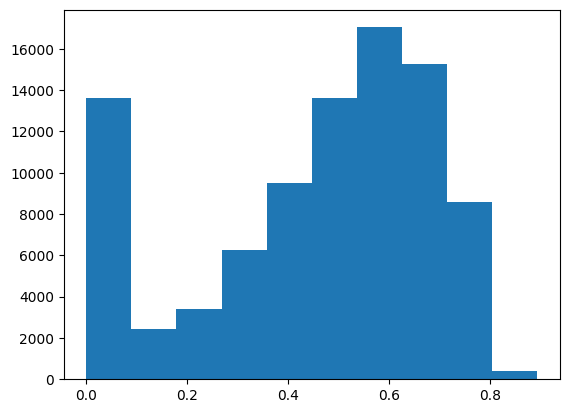

In [32]:
plt.hist(test_pred_total_mean)

In [34]:
test_pred_total_mean = np.mean(test_pred_total, axis=(0))
sample_submission = pd.read_csv('../sample_submission.csv')
sample_submission['probability'] = test_pred_total_mean
sample_submission.to_csv('CODE_recentgit_lgbmcat_cpu_mac_sunghyun+StandardScaler.csv', index=False)